TODO
- See https://github.com/csglab/CRIES
- Recount junction counts such that exon counts are intersected only with exons and *not* introns
- 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import collections
import concurrent.futures
import csv
import gc
import glob
import itertools
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pysam

In [3]:
dir_project = os.path.abspath('..')
dir_modules = os.path.join(dir_project, 'modules')
dir_scripts = os.path.join(dir_project, 'scripts')
dir_data = os.path.join(dir_project, 'data')
dir_data_aux = os.path.join(dir_project, 'data_aux')
dir_data_dedup = os.path.join(dir_data, 'dedup')
os.makedirs(dir_data_dedup, exist_ok=True)

In [4]:
sys.path.append(dir_modules)
import utils_genomics

# Constants

In [5]:
mouse_chromosomes_nuclear = [f'chr{i}' for i in range(1, 20)] + ['chrX', 'chrY']

In [6]:
directories_timecourse = [x for x in os.listdir(os.path.join(dir_data, 'fastqs')) if x.endswith('minchase')]

In [7]:
timepoints = sorted(map(lambda s: int(s.replace('minchase', '')), directories_timecourse))

In [8]:
columns_gtf = ['chr', 'source', 'feature type', 'start', 'end', 'score', 'strand', 'phase', 'additional']
columns_gff3 = ['chr', 'source', 'feature type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']

# Sequencing QC

Directories: `/central/groups/guttman/primarydata/sequencingruns/20220823/runfolders/volvox02/nextseq/220822_VH00472_97_AACCG37M5/Analysis/1/Data/fastq/[#]minchase` where `[#]` is one of 0, 10, 15, 20, 25, 30, 45, 60, 75, 90, 120, 240
- `aligned.MAPQ255.mouse.bam`: sorted (by coordinate) version of `aligned.mouse.bam`
- `aligned.mouse.bam`: already filtered for uniquely mapped primary alignments (no flags overlap `0x900`, and all MAPQs values output by STAR are 255)

Examine existing processed files

In [4]:
%%bash -s "$dir_data" "$dir_data_aux"
source ~/.bashrc
module load samtools/1.15

dir_data="$1"
dir_data_aux="$2"
dir_tmp_counts="$dir_data_aux"/tmp_counts
[ -d "$dir_tmp_counts" ] && rm -r "$dir_tmp_counts"
mkdir -p "$dir_tmp_counts"

for path in "$dir_data"/fastqs/*minchase; do
    timepoint=$(basename $path)
    echo "$timepoint" MAPQ255 $(samtools view "$path/aligned.MAPQ255STAR.mouse.bam" | wc -l) > \
        "$dir_tmp_counts"/"MAPQ255-$timepoint".count &
    echo "$timepoint" aligned $(samtools view "$path/aligned.mouse.bam" | wc -l) > \
        "$dir_tmp_counts"/"aligned-$timepoint".count &
    echo "$timepoint" aligned_primary $(samtools view -F 0x900 "$path/aligned.mouse.bam" | wc -l) > \
        "$dir_tmp_counts"/"aligned_primary-$timepoint".count &
    echo "$timepoint" unmapped1 $(wc -l "$path/Unmapped.out.mate1" | awk '{print $1/4}') > \
        "$dir_tmp_counts"/"unmapped1-$timepoint".count &
    echo "$timepoint" unmapped2 $(wc -l "$path/Unmapped.out.mate2" | awk '{print $1/4}') > \
        "$dir_tmp_counts"/"unmapped2-$timepoint".count &
    echo "$timepoint" trimmed1 $(zcat "$path/Trimmed_R1.fastq.gz" | wc -l | awk '{print $1/4}') > \
        "$dir_tmp_counts"/"trimmed-$timepoint".count &
    echo "$timepoint" trimmed2 $(zcat "$path/Trimmed_R2.fastq.gz" | wc -l | awk '{print $1/4}') > \
        "$dir_tmp_counts"/"trimmed2-$timepoint".count &
    echo "$timepoint" raw $(zcat "$path"/10min5EU_*R1_0*.fastq.gz | wc -l | awk '{print $1/4}') > \
        "$dir_tmp_counts"/"raw-$timepoint".count &
done
wait
cat "$dir_tmp_counts"/*.count > "$dir_data_aux"/n_reads.count
rm -r "$dir_tmp_counts"

In [8]:
df_qc = pd.read_csv(os.path.join(dir_data_aux, 'n_reads.count'), sep=' ', header=None, names=['directory', 'stage', 'count'])
df_qc['timepoint'] = df_qc['directory'].str.replace('minchase', '').astype(int)

In [9]:
assert all(df_qc.groupby('directory').apply(lambda x: x.loc[x['stage'] == 'aligned', 'count'].item() == x.loc[x['stage'] == 'MAPQ255', 'count'].item()))
assert all(df_qc.groupby('directory').apply(lambda x: x.loc[x['stage'] == 'aligned', 'count'].item() == x.loc[x['stage'] == 'aligned_primary', 'count'].item()))

<AxesSubplot: xlabel='trimmed1', ylabel='aligned'>

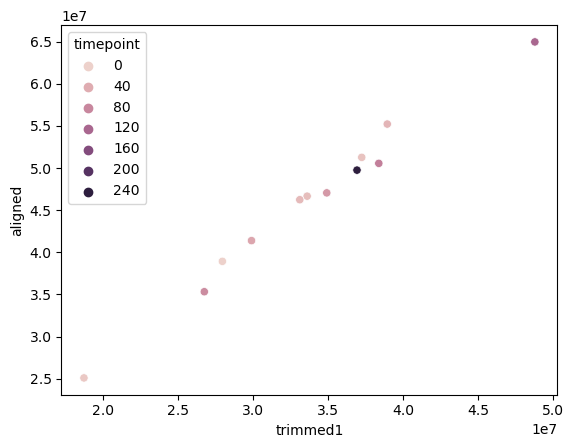

In [10]:
sns.scatterplot(
    df_qc.assign(timepoint=df_qc['directory'].str.replace('minchase', '').astype(int)) \
         .pivot(index='timepoint', columns='stage', values='count').reset_index(),
    x='trimmed1',
    y='aligned',
    hue='timepoint')

## PCR or optical duplicates

### Naively check for duplicate read sequences

In [ ]:
%%bash -s "$dir_data" "$dir_data_dedup"
source ~/.bashrc
module load samtools/1.15

dir_data="$1"
dir_dedup="$2"
dir_tmp_counts="$dir_dedup"/tmp_counts
[ -d "$dir_tmp_counts" ] && rm -r "$dir_tmp_counts"
mkdir -p "$dir_tmp_counts"

dir_tmp='/central/scratch/btyeh'

for path in "$dir_data"/fastqs/*minchase; do
    timepoint=$(basename $path)
    echo "$timepoint"
    file_out="${dir_tmp_counts}/${timepoint}.dups"
    echo "${timepoint} " > "${file_out}"
    samtools view "$path/aligned.MAPQ255STAR.mouse.bam" | cut -f 10 | sort -T "$dir_tmp" | uniq -c |
        sed -r 's/^\s+//g' | cut -d ' ' -f 1 | sort -n -T "$dir_tmp" | uniq -c >> "${file_out}" &
done
wait
cat "$dir_tmp_counts"/*.dups > "$dir_dedup"/exact_dups.count
rm -r "$dir_tmp_counts"

In [219]:
df_exact_dups_count = []
timepoint = None
with open(os.path.join(dir_data_dedup, 'exact_dups.count'), 'rt') as f:
    for line in f:
        if 'minchase' in line:
            timepoint = int(line.strip().replace('minchase', ''))
            continue
        assert timepoint is not None
        df_exact_dups_count.append((timepoint, *(line.split())))
df_exact_dups_count = pd.DataFrame(df_exact_dups_count, columns=['timepoint', 'n_seq', 'n_dups']).astype(dict(n_seq=int, n_dups=int))
# n_seq is the number of unique sequences each which were present n_dups times

[Text(0.5, 1.0, 'Distribution of duplications over all timepoints'),
 Text(0.5, 0, 'Duplication count'),
 Text(0, 0.5, 'Number of sequences'),
 None,
 None]

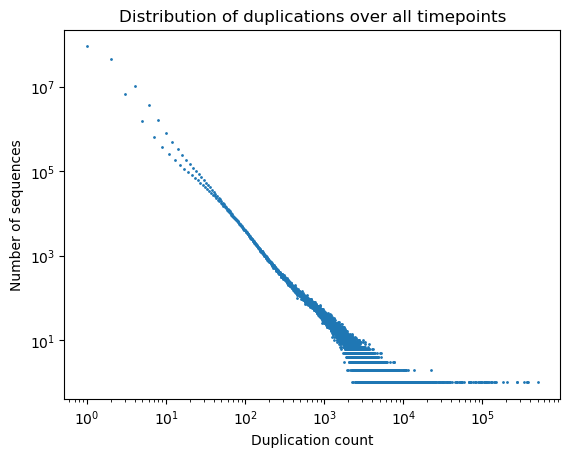

In [231]:
fig, ax = plt.subplots()
dist_dups = df_exact_dups_count.groupby('n_dups')['n_seq'].sum()
ax.scatter(dist_dups.index, dist_dups, s=1)
ax.set(
    title='Distribution of duplications over all timepoints',
    xlabel='Duplication count',
    ylabel='Number of sequences',
    xscale='log',
    yscale='log')

In [302]:
mask_dups = df_exact_dups_count['n_dups'] > 1
df_exact_dups_metrics = pd.concat((
    df_qc.loc[df_qc['stage'] == 'MAPQ255', ['count', 'timepoint']].set_index('timepoint').squeeze(),
    df_exact_dups_count.loc[mask_dups].groupby('timepoint').apply(
        lambda df: (df['n_seq'] * (df['n_dups'] - 1)).sum())), axis=1) \
    .rename(columns={'count': 'n_reads', 0: 'n_dups'}) \
    .pipe(lambda df: df.assign(**{'fraction duplicated': df['n_dups'] / df['n_reads']})).sort_index()

In [303]:
df_exact_dups_metrics

,n_reads,n_dups,fraction duplicated
timepoint,,,
0,38924721,24228809,0.622453
10,25090204,17077283,0.680635
15,51264586,32856923,0.640928
20,46660234,31353919,0.671962
25,46239308,33630137,0.727306
30,55217480,38304015,0.693694
45,41384392,28617867,0.691514
60,47051100,33141034,0.704363
75,35318865,25737947,0.728731


### Compare Picard and samtools

Either run the cell below or the following scripts:
- `samtools markdup`: `sbatch scripts/dedup_samtools.sbatch`
- Picard MarkDuplicates: `sbatch scripts/dedup_picard.sbatch`

In [ ]:
%%bash -s "$dir_data" "$dir_data_dedup"
source ~/.bashrc
module load samtools/1.15

dir_data="$1"
dir_dedup="$2"

dir_tmp='/central/scratch/btyeh'

for path in "$dir_data"/fastqs/*minchase; do
    timepoint=$(basename $path)
    samtools collate -O "$path/aligned.MAPQ255STAR.mouse.bam" "$dir_tmp/$timepoint" |
        samtools fixmate -m - - |
        samtools sort -T "$dir_tmp" -@ 4 |
        samtools markdup -T "$dir_tmp/" --threads 4 -d 2500 -f "${dir_dedup}/${timepoint}.markdup.metrics" - "${dir_dedup}/${timepoint}.markdup.bam" &
    java -jar ~/bin/picard.jar MarkDuplicates \
        -I "$path/aligned.MAPQ255STAR.mouse.bam" \
        -O "${dir_dedup}/${timepoint}.MarkDuplicates.bam" \
        -M "${dir_dedup}/${timepoint}.MarkDuplicates.metrics" \
        --TMP_DIR "$dir_tmp" \
        --TAGGING_POLICY All \
        --OPTICAL_DUPLICATE_PIXEL_DISTANCE 2500 &
    # java -jar ~/bin/picard.jar MarkDuplicates \
    #     -I "$path/aligned.MAPQ255STAR.mouse.bam" \
    #     -O /dev/stdout \
    #     -M "${dir_dedup}/${timepoint}.MarkDuplicates.metrics" \
    #     --TAGGING_POLICY All --OPTICAL_DUPLICATE_PIXEL_DISTANCE 2500 |
    # samtools collate -O - |
    #     samtools fixmate -m - - |
    #     samtools sort |
    #     samtools markdup -@ 4 -d 2500 -f "${dir_dedup}/${timepoint}.markdup.metrics" - "${dir_dedup}/${timepoint}.markdup.bam"
done

#### Global comparison

Parse `samtools markdup` metrics

In [125]:
df_dedup_metrics_samtools = []
for file in glob.glob(os.path.join(dir_data_dedup, '*.markdup.metrics')):
    timepoint = int(os.path.basename(file).split('.')[0])
    s = pd.read_csv(file, sep=': ', index_col=0, header=None, skiprows=1, engine='python').squeeze('columns')
    s.name = timepoint
    df_dedup_metrics_samtools.append(s)
df_dedup_metrics_samtools = pd.concat(df_dedup_metrics_samtools, axis=1).T.sort_index()
df_dedup_metrics_samtools['fraction duplicated'] = df_dedup_metrics_samtools['DUPLICATE TOTAL'] / df_dedup_metrics_samtools['READ']

In [126]:
df_dedup_metrics_samtools_long = df_dedup_metrics_samtools \
    .reset_index().rename(columns={'index': 'timepoint'}) \
    .melt(id_vars='timepoint', var_name='variable') \
    .assign(program='samtools')

Parse Picard `MarkDuplicates` metrics

In [128]:
df_dedup_metrics_picard = []
for file in glob.glob(os.path.join(dir_data_dedup, '*.MarkDuplicates.metrics')):
    timepoint = int(os.path.basename(file).split('.')[0])
    s = pd.read_csv(file, sep='\s+', header=0, engine='python', comment='#', nrows=1).squeeze('rows')
    s.name = timepoint
    df_dedup_metrics_picard.append(s)
df_dedup_metrics_picard = pd.concat(df_dedup_metrics_picard, axis=1).T.sort_index().drop(columns=['LIBRARY'])
df_dedup_metrics_picard['fraction duplicated'] = (
    df_dedup_metrics_picard['READ_PAIR_DUPLICATES'] +
    df_dedup_metrics_picard['UNPAIRED_READ_DUPLICATES']) / (
    df_dedup_metrics_picard['UNPAIRED_READS_EXAMINED'] + 
    df_dedup_metrics_picard['READ_PAIRS_EXAMINED'])

Reformat Picard MarkDuplicates metrics in the samtools metrics format

In [129]:
df_dedup_metrics_picard_reformat = df_dedup_metrics_picard.rename(columns=dict(
    UNPAIRED_READS_EXAMINED='SINGLE',
    READ_PAIRS_EXAMINED='PAIRED',
    UNPAIRED_READ_DUPLICATES='DUPLICATE SINGLE',
    READ_PAIR_DUPLICATES='DUPLICATE PAIR',
    READ_PAIR_OPTICAL_DUPLICATES='DUPLICATE PAIR OPTICAL')) \
    .drop(columns='SECONDARY_OR_SUPPLEMENTARY_RDS')
df_dedup_metrics_picard_reformat['PAIRED'] *= 2
df_dedup_metrics_picard_reformat['DUPLICATE PAIR'] *= 2
df_dedup_metrics_picard_reformat['DUPLICATE PAIR OPTICAL'] *= 2
df_dedup_metrics_picard_reformat_long = df_dedup_metrics_picard_reformat \
    .reset_index().rename(columns={'index': 'timepoint'}) \
    .melt(id_vars='timepoint') \
    .assign(program='picard')

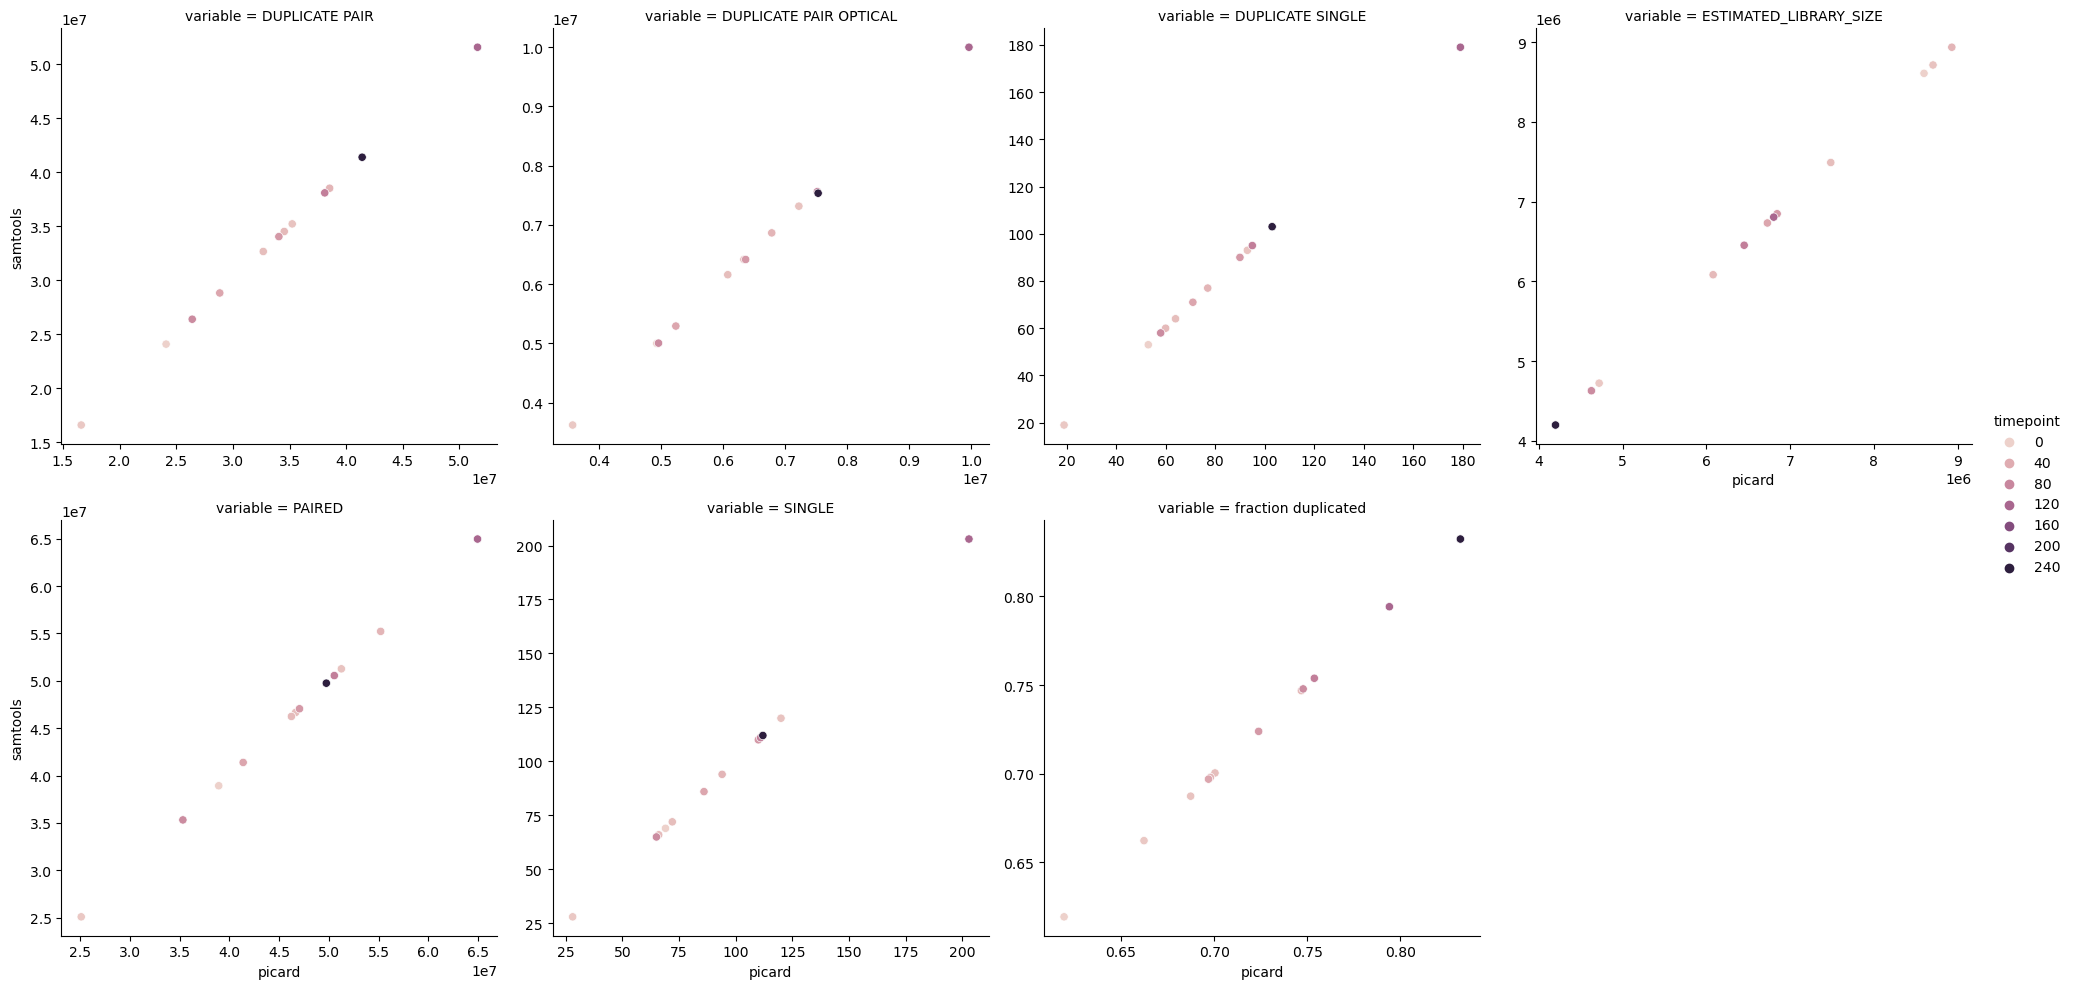

In [232]:
df_dedup_metrics_compare = pd.concat((df_dedup_metrics_picard_reformat_long, df_dedup_metrics_samtools_long), axis=0) \
    .reset_index(drop=True) \
    .pivot(index=['timepoint', 'variable'], columns='program', values='value') \
    .dropna() \
    .reset_index()
sns.relplot(
    kind='scatter',
    data=df_dedup_metrics_compare,
    x='picard', y='samtools',
    hue='timepoint',
    col='variable',
    col_wrap=4,
    aspect=1,
    facet_kws=dict(sharex=False, sharey=False))

In [305]:
df_fraction_dedup_compare = pd.DataFrame({
    'Picard': df_dedup_metrics_picard['fraction duplicated'],
    'samtools': df_dedup_metrics_samtools['fraction duplicated'],
    'exact duplicates': df_exact_dups_metrics['fraction duplicated']})
df_fraction_dedup_compare

,Picard,samtools,exact duplicates
0,0.61935,0.619350,0.622453
10,0.662307,0.662307,0.680635
15,0.687379,0.687378,0.640928
20,0.700461,0.700461,0.671962
25,0.746869,0.746869,0.727306
30,0.697981,0.697981,0.693694
45,0.696972,0.696972,0.691514
60,0.723918,0.723918,0.704363
75,0.747846,0.747846,0.728731
90,0.753852,0.753852,0.719913


<AxesSubplot: xlabel='timepoint', ylabel='fraction duplicated'>

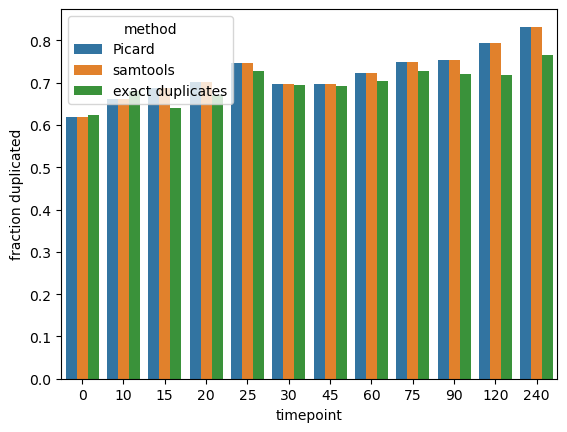

In [312]:
sns.barplot(
    data=df_fraction_dedup_compare \
        .reset_index().rename(columns={'index': 'timepoint'}) \
        .melt(id_vars='timepoint', var_name='method', value_name='fraction duplicated'),
    x='timepoint',
    y='fraction duplicated',
    hue='method')

#### Read-by-read comparison

For a given position, `samtools` and Picard mark a different number of templates as duplicated.

##### Specific example: `chr1:72226366`

Forward and reverse reads mapped to position `chr1:72226366`
- Except for 2 read pairs (`VH00472:4:AACCG37M5:1:1206:77026:26047`, `VH00472:4:AACCG37M5:1:2105:46672:50372`), both the forward and reverse reads of the template align to `chr1:72226366`, suggesting that the template length was shorter than the read length
- Picard does not mark any of the duplicate templates as a potential unique template (unclear what is the corresponding unique template??), whereas `samtools` marks one of the templates (`VH00472:4:AACCG37M5:1:2404:24139:40604`) as a unique template.

In [122]:
%%bash -s "$dir_data"
source ~/.bashrc
module load samtools/1.15

dir_data="$1"
dir_data_dedup="${dir_data}/dedup"

echo '-- samtools markdup, forward reads --'
samtools view -@ 10 --exclude-flags 0x10 "${dir_data_dedup}/0.markdup.bam" | 
    grep -E "^\S+\s\S+\schr1\s72226366\s"  | # > "${dir_data_dedup}/0.markdup.chr1_72226366.sam"
    cut -f 1,2,8,12- |
    sort
echo '-- reverse reads --'
samtools view -@ 10 --include-flags 0x10 "${dir_data_dedup}/0.markdup.bam" | 
    grep -E "^\S+\s\S+\schr1\s72226366\s"  | # > "${dir_data_dedup}/0.markdup.chr1_72226366.sam"
    cut -f 1,2,8,12- |
    sort
echo ''
echo '-- Picard MarkDuplicates, forward reads --'
samtools view -@ 10 --exclude-flags 0x10 "${dir_data_dedup}/0.MarkDuplicates.bam" |
    grep -E "^\S+\s\S+\schr1\s72226366\s" | # > "${dir_data_dedup}/0.MarkDuplicates.chr1_72226366.sam"
    cut -f 1,2,8,12- | 
    sort
echo '-- reverse reads --'
samtools view -@ 10 --include-flags 0x10 "${dir_data_dedup}/0.MarkDuplicates.bam" |
    grep -E "^\S+\s\S+\schr1\s72226366\s" | # > "${dir_data_dedup}/0.MarkDuplicates.chr1_72226366.sam"
    cut -f 1,2,8,12- |
    sort

-- samtools markdup, forward reads --
VH00472:4:AACCG37M5:1:1103:74697:33751	1187	72226366	NH:i:1	HI:i:1	AS:i:144	nM:i:0	MQ:i:255	MC:Z:1S73M	ms:i:2398	dt:Z:LB
VH00472:4:AACCG37M5:1:1106:55629:39828	1187	72226366	NH:i:1	HI:i:1	AS:i:146	nM:i:0	MQ:i:255	MC:Z:1S74M	ms:i:2542	dt:Z:LB
VH00472:4:AACCG37M5:1:1210:73334:20462	1187	72226366	NH:i:1	HI:i:1	AS:i:146	nM:i:0	MQ:i:255	MC:Z:1S74M	ms:i:2550	dt:Z:SQ
VH00472:4:AACCG37M5:1:1210:73485:18266	1187	72226366	NH:i:1	HI:i:1	AS:i:146	nM:i:0	MQ:i:255	MC:Z:1S74M	ms:i:2542	dt:Z:LB
VH00472:4:AACCG37M5:1:1405:18591:52284	1187	72226366	NH:i:1	HI:i:1	AS:i:146	nM:i:0	MQ:i:255	MC:Z:1S74M	ms:i:2516	dt:Z:LB
VH00472:4:AACCG37M5:1:1607:12532:47211	1187	72226366	NH:i:1	HI:i:1	AS:i:146	nM:i:0	MQ:i:255	MC:Z:1S74M	ms:i:2068	dt:Z:LB
VH00472:4:AACCG37M5:1:1607:22700:37159	1187	72226366	NH:i:1	HI:i:1	AS:i:146	nM:i:0	MQ:i:255	MC:Z:1S74M	ms:i:2550	dt:Z:LB
VH00472:4:AACCG37M5:1:2207:33380:39203	1187	72226366	NH:i:1	HI:i:1	AS:i:152	nM:i:0	MQ:i:255	MC:Z:1S77M	ms:i:2552	dt

##### Categorize differences between Picard and samtools

- different flags, same everything else
- different tags, same everything else
- different flags and tags, same everything else
- different otherwise

In [8]:
batch_size = 100000
tags_to_remove = set(['PG:Z:MarkDuplicates'])
sam_dtypes = dict(flag=int, ref_pos=int, map_quality=int)

In [9]:
for timepoint in timepoints:
    with pysam.AlignmentFile(os.path.join(dir_data_dedup, f'{timepoint}.MarkDuplicates.bam'), 'rb') as fo_picard, \
         pysam.AlignmentFile(os.path.join(dir_data_dedup, f'{timepoint}.markdup.bam'), 'rb') as fo_samtools:
        df_diff_remaining = []
        iterator_picard = fo_picard.fetch(until_eof=True)
        iterator_samtools = fo_samtools.fetch(until_eof=True)
        qnames_picard = collections.Counter()
        qnames_samtools = collections.Counter()
        reads_picard, reads_samtools = [], []
        n_alignments_parsed = 0
        df_picard_remaining = None
        df_samtools_remaining = None
        for (read_picard, read_samtools) in tqdm(itertools.zip_longest(iterator_picard, iterator_samtools), mininterval=1):
            n_alignments_parsed += 1
            reads_picard.append(read_picard.to_dict())
            reads_samtools.append(read_samtools.to_dict())
            if n_alignments_parsed % batch_size == 0:
                df_picard = pd.DataFrame(reads_picard).astype(sam_dtypes)
                df_picard['tags'] = df_picard['tags'].map(lambda tags: tuple(sorted(set(map(lambda tag: tag.replace('DT:Z', 'dt:Z'), tags)) - tags_to_remove)))
                qnames_picard.update(df_picard['name'])
                df_picard = pd.concat((df_picard, df_picard_remaining), axis=0)
                df_samtools = pd.DataFrame(reads_samtools).astype(sam_dtypes)
                df_samtools['tags'] = df_samtools['tags'].map(lambda tags: tuple(sorted((tag for tag in tags if not (tag.startswith('MC:Z') or tag.startswith('MQ:i') or tag.startswith('ms:i'))))))
                qnames_samtools.update(df_samtools['name'])
                df_samtools = pd.concat((df_samtools, df_samtools_remaining), axis=0)
                df_diff = df_picard.merge(df_samtools, how='outer', indicator=True).pipe(lambda df: df.loc[df['_merge'] != 'both'])

                # mark QNAMES for which both pairs of reads have been read
                # if these are different, then they no longer need to be compared
                qnames_done = set()
                for qname in set(df_diff['name']):
                    if qnames_picard[qname] == 2 and qnames_samtools[qname] == 2:
                        qnames_done.add(qname)
                df_diff_remaining.append(df_diff.loc[df_diff['name'].isin(qnames_done)])
                qnames_remaining = set(df_diff['name']) - qnames_done

                df_picard_remaining = df_picard.loc[df_picard['name'].isin(qnames_remaining)]
                df_samtools_remaining = df_samtools.loc[df_samtools['name'].isin(qnames_remaining)]
                print(len(df_diff), len(qnames_done), len(qnames_remaining), n_alignments_parsed)
                
                del reads_picard, reads_samtools
                reads_picard = []
                reads_samtools = []
                gc.collect()
    break

[E::idx_find_and_load] Could not retrieve index file for '/central/groups/guttman/btyeh/splicing-kinetics/data/dedup/0.MarkDuplicates.bam'
[E::idx_find_and_load] Could not retrieve index file for '/central/groups/guttman/btyeh/splicing-kinetics/data/dedup/0.markdup.bam'


0it [00:00, ?it/s]

3840 960 0 100000
3918 978 3 200000
5554 944 918 300000
10104 2514 41 400000
3462 865 1 500000
11106 2776 1 600000
4604 1148 11 700000
4818 1201 9 800000
11070 2767 1 900000
5052 1262 3 1000000
7880 1572 980 1100000
20310 4718 1110 1200000
10590 2647 1 1300000
16376 4009 298 1400000
11690 2922 1 1500000
3490 872 1 1600000
4190 1047 1 1700000
14474 1672 5890 1800000
26778 6205 1776 1900000
13546 3386 1 2000000
5548 1386 3 2100000
5744 1346 187 2200000
5134 1283 1 2300000
3882 970 1 2400000
4334 1083 1 2500000
3844 960 2 2600000
15470 756 11022 2700000
19658 2889 4762 2800000
23144 3992 3886 2900000
24326 4410 3555 3000000
22596 4834 1707 3100000
20474 4381 1687 3200000
17236 4207 331 3300000
5890 1469 7 3400000
4546 1133 7 3500000
3710 924 7 3600000
7378 1840 11 3700000
9532 2378 12 3800000
9576 2390 9 3900000
4474 1115 7 4000000
3990 994 7 4100000
3954 985 7 4200000
8126 2026 15 4300000
4142 1032 7 4400000
5542 1342 141 4500000
3924 977 9 4600000
4562 1137 7 4700000
3982 991 9 4800000


In [ ]:
df_diff_tot = pd.concat(df_diff_remaining, axis=0, ignore_index=True).astype(dict(next_ref_pos=int, length=int, ref_name='category'))

In [40]:
df_diff_tot['rev'] = df_diff_tot['flag'].map(lambda s: s & 0x10 > 0)

In [14]:
len(df_diff_tot)

4688548

In [18]:
df_diff_tot.groupby('name', sort=False).apply(len).value_counts()

4    1172137
dtype: int64

In [41]:
df_diff_tot.groupby(['name', 'rev'], sort=False).apply(len).value_counts()

2    2344274
dtype: int64

In [22]:
df_diff_tot.head(10000).groupby(['name', 'ref_pos'], sort=False).filter(lambda df: len(df) == 4).sort_values(['name', '_merge'])

,name,flag,ref_name,ref_pos,map_quality,cigar,next_ref_name,next_ref_pos,length,seq,qual,tags,_merge
8082,VH00472:4:AACCG37M5:1:1102:28930:40813,1123,chr1,56782261,255,143M8S,=,56782261,83,CGTTATCGGAATTAACCAGACAAATCGCTCCACCAACTAAGAACGG...,CCCCCCCCCCCCCCCCCCCC;CCCCCCCCCCCCCC;;CCCCCC;CC...,"(AS:i:204, HI:i:1, NH:i:1, dt:Z:LB, nM:i:10)",left_only
8084,VH00472:4:AACCG37M5:1:1102:28930:40813,1171,chr1,56782261,255,7S83M61S,=,56782261,-83,GCGATCTCGTTATCGGAATTAACCAGACAAATCGCTCCACCAACTA...,-CCCC;CC;CCCCC;CC;-CCCCC;;CC;--CCCC;C;C;CCC-;C...,"(AS:i:204, HI:i:1, NH:i:1, dt:Z:LB, nM:i:10)",left_only
9971,VH00472:4:AACCG37M5:1:1102:28930:40813,1123,chr1,56782261,255,143M8S,=,56782261,83,CGTTATCGGAATTAACCAGACAAATCGCTCCACCAACTAAGAACGG...,CCCCCCCCCCCCCCCCCCCC;CCCCCCCCCCCCCC;;CCCCCC;CC...,"(AS:i:204, HI:i:1, NH:i:1, dt:Z:SQ, nM:i:10)",right_only
9973,VH00472:4:AACCG37M5:1:1102:28930:40813,1171,chr1,56782261,255,7S83M61S,=,56782261,-83,GCGATCTCGTTATCGGAATTAACCAGACAAATCGCTCCACCAACTA...,-CCCC;CC;CCCCC;CC;-CCCCC;;CC;--CCCC;C;C;CCC-;C...,"(AS:i:204, HI:i:1, NH:i:1, dt:Z:SQ, nM:i:10)",right_only
8083,VH00472:4:AACCG37M5:1:1102:28987:40831,1123,chr1,56782261,255,136M15S,=,56782261,125,CGTTATCGGAATTAACCAGACAAATCGCTCCACCAACTAAGAACGG...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC;CCCCC;CCCC...,"(AS:i:243, HI:i:1, NH:i:1, dt:Z:SQ, nM:i:8)",left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9834,VH00472:4:AACCG37M5:1:2611:23590:45356,1171,chr1,56782207,255,4S146M1S,=,56782207,-146,CTGGGGGACGCCGACCGCTCGGGGGTCGCGTAACTAGTTAGCATGC...,C;CCCCC;CCCCCC;CCCCCC;CCCCCCCCCCCCCCC-CCCCCCCC...,"(AS:i:274, HI:i:1, NH:i:1, dt:Z:SQ, nM:i:8)",right_only
7937,VH00472:4:AACCG37M5:1:2611:23704:45356,1123,chr1,56782207,255,2S146M3S,=,56782207,146,GGGGGACGCCGACCGCTCGGGGGTCGCGTAACTAGTTAGCATGCCA...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,"(AS:i:274, HI:i:1, NH:i:1, dt:Z:SQ, nM:i:8)",left_only
7946,VH00472:4:AACCG37M5:1:2611:23704:45356,1171,chr1,56782207,255,4S146M1S,=,56782207,-146,CTGGGGGACGCCGACCGCTCGGGGGTCGCGTAACTAGTTAGCATGC...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,"(AS:i:274, HI:i:1, NH:i:1, dt:Z:SQ, nM:i:8)",left_only
9820,VH00472:4:AACCG37M5:1:2611:23704:45356,1123,chr1,56782207,255,2S146M3S,=,56782207,146,GGGGGACGCCGACCGCTCGGGGGTCGCGTAACTAGTTAGCATGCCA...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,"(AS:i:274, HI:i:1, NH:i:1, dt:Z:LB, nM:i:8)",right_only


In [47]:
grouped = df_diff_tot.groupby(['name', 'rev'], sort=False)

In [ ]:
df_diff_flag, df_diff_tags, df_diff_flags_and_tags, df_diff_other = [], [], [], []
no_diff = 0
diff_flag_by_1 = 0
diff_tags = 0
diff_flag_by_1_and_tags = 0
set_flags = {'flag'}
set_tags = {'tags'}
set_flags_and_tags = set_flags | set_tags
set_dt_tags = set(['dt:Z:LB', 'dt:Z:SQ'])
set_merge = {'_merge'}
set_indicators = {'right_only', 'left_only'}
for name, group in tqdm(grouped):
    assert len(group) == 2
    assert set(group['_merge']) == set_indicators
    if len(group[['name', 'ref_name', 'ref_pos', 'map_quality', 'cigar', 'next_ref_name', 'next_ref_pos', 'length', 'seq', 'qual']].drop_duplicates()) == 1:
        mask_picard = group['_merge'] == 'left_only'
        read_picard = group.loc[mask_picard].squeeze()
        read_samtools = group.loc[~mask_picard].squeeze()
        different_fields = set(read_picard.index[read_picard != read_samtools]) - set_merge
        if len(different_fields) == 0:
            no_diff += 1
        elif different_fields == set_flags:
            if read_picard['flag'] - read_samtools['flag'] == 1:
                diff_flag_by_1 += 1
            else:
                df_diff_flag.append(group)
        elif different_fields == set_tags:
            if (set(read_picard['tags']) ^ set(read_samtools['tags'])) == set_dt_tags:
                diff_tags += 1
            else:
                df_diff_tags.append(group)
        elif different_fields == set_flags_and_tags:
            if (read_picard['flag'] - read_samtools['flag'] == 1) and ((set(read_picard['tags']) ^ set(read_samtools['tags'])) == set_dt_tags):
                diff_flag_by_1_and_tags += 1
            else:
                df_diff_flags_and_tags.append(group)
        else:
            assert False
    else:
        df_diff_other.append(group)

  0%|          | 0/2344274 [00:00<?, ?it/s]

In [ ]:
f'no_diff: {no_diff}, diff_flag_by_1: {diff_flag_by_1}, diff_tags: {diff_tags}, diff_flag_by_1_and_tags: {diff_flag_by_1_and_tags}'

In [56]:
print(len(df_diff_flag), len(df_diff_tags), len(df_diff_flags_and_tags), len(df_diff_other))

0 0 17728 0


In [82]:
df_diff_flags_and_tags = pd.concat(df_diff_flags_and_tags, axis=0)

In [90]:
for name, group in df_diff_flags_and_tags.groupby(['ref_name', 'ref_pos', 'rev']):
    mask_picard = group['_merge'] == 'left_only'
    picard_reads = group.loc[mask_picard]
    samtools_reads = group.loc[~mask_picard]
    assert len(picard_reads) == len(samtools_reads)
    assert picard_reads['tags'].map(lambda tags: not any((tag.startswith('dt:Z:') for tag in tags))).sum() == 1
    assert samtools_reads['tags'].map(lambda tags: not any((tag.startswith('dt:Z:') for tag in tags))).sum() == 1

AssertionError: 

In [114]:
for timepoint in tqdm(timepoints):
    picard_diff = []
    with open(os.path.join(dir_data_dedup, f'{timepoint}.picard_diff.tsv'), 'rt') as f:
        for line in tqdm(f):
            elems = line.strip().split('\t')
            d = dict(name=elems[0], flag=int(elems[1]))
            d.update({elem[:2]: elem.split(':')[-1] for elem in elems[2:]})
            picard_diff.append(d)
    picard_diff = pd.DataFrame(picard_diff).astype(dict(AS=int, HI=int, NH=int, dt='category', nM=int))
    
    samtools_diff = []
    with open(os.path.join(dir_data_dedup, f'{timepoint}.samtools_diff.tsv'), 'rt') as f:
        for line in tqdm(f):
            elems = line.strip().split('\t')
            d = dict(name=elems[0], flag=int(elems[1]))
            d.update({elem[:2]: elem.split(':')[-1] for elem in elems[2:]})
            samtools_diff.append(d)
    samtools_diff = pd.DataFrame(samtools_diff).astype(dict(AS=int, HI=int, NH=int, dt='category', nM=int))

    assert len(samtools_diff) == len(picard_diff)
    
    diff_tag = samtools_diff.merge(picard_diff, how='inner', on=['name', 'flag', 'AS', 'HI', 'NH', 'nM'], indicator=True)
    assert diff_tag['dt_x'].isin(['LB', 'SQ']).all()
    assert diff_tag['dt_y'].isin(['LB', 'SQ']).all()
    print(f'-- Timepoint: {timepoint} --')
    print((f'Different tags, same flags --> accounts for {len(diff_tag)} / {len(picard_diff)}'
           f' = {len(diff_tag) / len(picard_diff):.2f} of different reads'))

    diff_flag = samtools_diff.merge(picard_diff, how='inner', on=['name', 'AS', 'HI', 'NH', 'dt', 'nM'], indicator=True)
    assert all(diff_flag['flag_y'] - diff_flag['flag_x'] == 1)
    print((f'Different flags (off by 1), same tags --> accounts for {len(diff_flag)} / {len(picard_diff)}'
           f' = {len(diff_flag) / len(picard_diff):.2f} of different reads'))
    
    picard_diff_remaining = picard_diff \
        .merge(
            diff_flag.drop(columns=['flag_x', '_merge']).rename(columns=dict(flag_y='flag')),
            how='left',
            indicator=True) \
        .pipe(lambda df: df.loc[df['_merge'] == 'left_only']) \
        .drop(columns=['_merge'])
    picard_diff_remaining = picard_diff_remaining \
        .merge(
            diff_tag.drop(columns=['dt_x', '_merge']).rename(columns=dict(dt_y='dt')),
            how='left',
            indicator=True) \
        .pipe(lambda df: df.loc[df['_merge'] == 'left_only']) \
        .drop(columns=['_merge']) \
        .pipe(lambda df: df.assign(reverse=df['flag'].map(lambda flag: flag & 0x10 > 0)))
    samtools_diff_remaining = samtools_diff \
        .merge(
            diff_flag.drop(columns=['flag_y', '_merge']).rename(columns=dict(flag_x='flag')),
            how='left',
            indicator=True) \
        .pipe(lambda df: df.loc[df['_merge'] == 'left_only']) \
        .drop(columns=['_merge'])
    samtools_diff_remaining = samtools_diff_remaining \
        .merge(
            diff_tag.drop(columns=['dt_y', '_merge']).rename(columns=dict(dt_x='dt')),
            how='left',
            indicator=True) \
        .pipe(lambda df: df.loc[df['_merge'] == 'left_only']) \
        .drop(columns=['_merge']) \
        .pipe(lambda df: df.assign(reverse=df['flag'].map(lambda flag: flag & 0x10 > 0)))
    assert len(samtools_diff_remaining) == len(picard_diff_remaining)
    assert len(samtools_diff_remaining) + len(diff_tag) + len(diff_flag) == len(picard_diff)
    diff_remaining = samtools_diff_remaining.merge(
        picard_diff_remaining,
        how='inner',
        on=['name', 'AS', 'HI', 'NH', 'nM', 'reverse'],
        indicator=True)
    assert diff_remaining['dt_x'].isna().sum() == diff_remaining['dt_y'].isna().sum()

  0%|          | 0/12 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

-- Timepoint: 0 --
Different tags, same flags --> accounts for 2327398 / 2345211 = 0.99 of different reads
Different flags (off by 1), same tags --> accounts for 66 / 2345211 = 0.00 of different reads


0it [00:00, ?it/s]

0it [00:00, ?it/s]

-- Timepoint: 10 --
Different tags, same flags --> accounts for 1725084 / 1739712 = 0.99 of different reads
Different flags (off by 1), same tags --> accounts for 26 / 1739712 = 0.00 of different reads


0it [00:00, ?it/s]

0it [00:00, ?it/s]

-- Timepoint: 15 --
Different tags, same flags --> accounts for 3781188 / 3807392 = 0.99 of different reads
Different flags (off by 1), same tags --> accounts for 109 / 3807392 = 0.00 of different reads


0it [00:00, ?it/s]

0it [00:00, ?it/s]

-- Timepoint: 20 --
Different tags, same flags --> accounts for 3318724 / 3337636 = 0.99 of different reads
Different flags (off by 1), same tags --> accounts for 69 / 3337636 = 0.00 of different reads


0it [00:00, ?it/s]

0it [00:00, ?it/s]

-- Timepoint: 25 --
Different tags, same flags --> accounts for 3712948 / 3732642 = 0.99 of different reads
Different flags (off by 1), same tags --> accounts for 64 / 3732642 = 0.00 of different reads


0it [00:00, ?it/s]

0it [00:00, ?it/s]

-- Timepoint: 30 --
Different tags, same flags --> accounts for 3759216 / 3782702 = 0.99 of different reads
Different flags (off by 1), same tags --> accounts for 83 / 3782702 = 0.00 of different reads


0it [00:00, ?it/s]

0it [00:00, ?it/s]

-- Timepoint: 45 --
Different tags, same flags --> accounts for 2920500 / 2937650 = 0.99 of different reads
Different flags (off by 1), same tags --> accounts for 81 / 2937650 = 0.00 of different reads


0it [00:00, ?it/s]

0it [00:00, ?it/s]

-- Timepoint: 60 --
Different tags, same flags --> accounts for 3710484 / 3729134 = 0.99 of different reads
Different flags (off by 1), same tags --> accounts for 98 / 3729134 = 0.00 of different reads


0it [00:00, ?it/s]

0it [00:00, ?it/s]

-- Timepoint: 75 --
Different tags, same flags --> accounts for 2969254 / 2983331 = 1.00 of different reads
Different flags (off by 1), same tags --> accounts for 65 / 2983331 = 0.00 of different reads


0it [00:00, ?it/s]

0it [00:00, ?it/s]

-- Timepoint: 90 --
Different tags, same flags --> accounts for 4543510 / 4563817 = 1.00 of different reads
Different flags (off by 1), same tags --> accounts for 103 / 4563817 = 0.00 of different reads


0it [00:00, ?it/s]

0it [00:00, ?it/s]

-- Timepoint: 120 --
Different tags, same flags --> accounts for 6432370 / 6453849 = 1.00 of different reads
Different flags (off by 1), same tags --> accounts for 180 / 6453849 = 0.00 of different reads


0it [00:00, ?it/s]

0it [00:00, ?it/s]

-- Timepoint: 240 --
Different tags, same flags --> accounts for 5173414 / 5186306 = 1.00 of different reads
Different flags (off by 1), same tags --> accounts for 109 / 5186306 = 0.00 of different reads


TODO: Using GNU coreutils: `comm` and `join`

1. Verify that all fields are identical except for flags and tags: see `scripts/dedup_diff_no_flags_or_tags.sbatch`
2. Join on (template name and whether the read is in the forward or reverse orientation) -->
   - different flags, same tags
   - different tags, same flags
   - different flags and tags

### Deduplicate marked BAM files

In [337]:
%%bash -s "$dir_data_dedup"
source ~/.bashrc
module load samtools/1.15

dir_data_dedup="$1"

for path in "$dir_data_dedup"/*.MarkDuplicates.bam; do
    file_marked=$(basename $path)
    file_dedup="${file_marked%.*}".dedup.bam
    # exclude reads with 0x400 flag (PCR or optical duplicate)
    samtools view -h --threads 20 --exclude-flags 0x400 "${dir_data_dedup}/${file_marked}" -o "${dir_data_dedup}/${file_dedup}"
    samtools index -@ 10 "${dir_data_dedup}/${file_dedup}"
done

#### Compare with Mitch's deduplicated files

In [137]:
%%bash -s "$dir_data_aux" "$dir_data_dedup"
source ~/.bashrc
module load samtools/1.15

dir_data_aux="$1"
dir_data_dedup="$2"

for path in "$dir_data_dedup"/*MarkDuplicates.dedup.bam; do
    file=$(basename $path)
    echo -n -e "${file}\t" >> "${dir_data_aux}/dedup.count"
    samtools view -@ 20 "$path" | wc -l >> "${dir_data_aux}/dedup.count"
done

In [322]:
%%bash -s "$dir_data_aux"
source ~/.bashrc
module load samtools/1.15

dir_data_aux="$1"
dir_dedup_mitch='/central/groups/guttman/mguttman/Splicing/dedup'

for path in "$dir_dedup_mitch"/*.bam; do
    file=$(basename $path)
    echo -n -e "${file}\t" >> "${dir_data_aux}/dedup_mitch.count"
    samtools view --exclude-flags 0x400 -@ 20 "$path" | wc -l >> "${dir_data_aux}/dedup_mitch.count"
done

<AxesSubplot: xlabel='timepoint', ylabel='unique reads'>

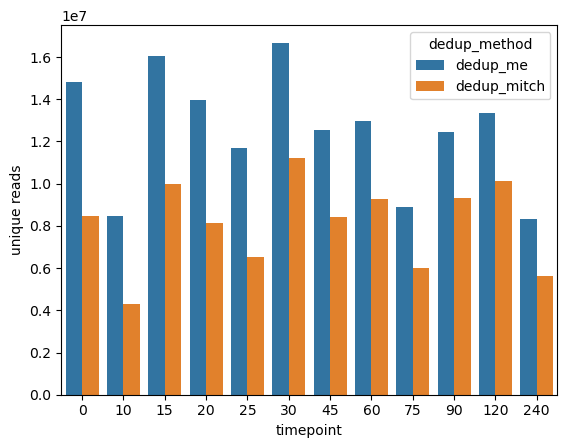

In [326]:
df_dedup_counts_compare_mitch = pd.concat(
    (
        pd.read_csv(os.path.join(dir_data_aux, 'dedup.count'), sep='\t', header=None, names=['file', 'dedup_me']) \
            .pipe(lambda df: df.assign(timepoint=df['file'].str.extract('(\d+)').astype(int))) \
            .drop(columns=['file']) \
            .set_index('timepoint') \
            .squeeze(),
        pd.read_csv(os.path.join(dir_data_aux, 'dedup_mitch.count'), sep='\t', header=None, names=['file', 'dedup_mitch']) \
            .pipe(lambda df: df.assign(timepoint=df['file'].str.extract('(\d+)').astype(int))) \
            .drop(columns=['file']) \
            .set_index('timepoint') \
            .squeeze()),
    axis=1).sort_index()
sns.barplot(
    df_dedup_counts_compare_mitch.reset_index().rename(columns={'index': 'timepoint'}) \
        .melt(id_vars=['timepoint'], var_name='dedup_method', value_name='unique reads'),
    x='timepoint',
    y='unique reads',
    hue='dedup_method')

### Statistics of deduplicated BAM alignments

In [ ]:
%%bash -s "$dir_data_dedup"
set -e -o pipefail
source ~/.bashrc
module load samtools/1.15

dir_data_dedup="$1"

for path_dedup in "$dir_data_dedup"/*.MarkDuplicates.dedup.bam; do
    file_dedup="$(basename $path_dedup)"
    file_idxstats="${file_dedup%.*}.idxstats"
    file_stats="${file_dedup%.*}.stats"
    file_coverage="${file_dedup%.*}.coverage"
    samtools idxstats "$path_dedup" > "${dir_data_dedup}/$file_idxstats" &
    samtools stats --threads 10 "$path_dedup" > "${dir_data_dedup}/$file_stats"
    samtools coverage -o "${dir_data_dedup}/$file_coverage" "$path_dedup" &
done

`idxstats`: Aligned reads per chromosome

In [245]:
df_idxstats = []
for timepoint in timepoints:
    df_idxstats.append(pd.read_csv(
        os.path.join(dir_data_dedup, f'{timepoint}.MarkDuplicates.dedup.idxstats'),
        sep='\t',
        header=None,
        names=['chr', 'length', '# mapped read segments', '# unmapped read segments']) \
        .assign(timepoint=timepoint))
df_idxstats = pd.concat(df_idxstats, axis=0) \
    .reset_index(drop=True) \
    .pipe(lambda df: df.loc[df['chr'].isin(mouse_chromosomes_nuclear)])

In [248]:
assert (df_idxstats['# unmapped read segments'] == 0).all()
df_idxstats.drop(columns='# unmapped read segments', inplace=True)

In [257]:
df_idxstats.pivot(index='chr', columns='timepoint', values='# mapped read segments') \
    .sort_index(key=lambda v: [mouse_chromosomes_nuclear.index(elem) for elem in v]) \
    .pipe(lambda df: df.assign(sum=df.sum(axis=1)))

timepoint,0,10,15,20,25,30,45,60,75,90,120,240,sum
chr,,,,,,,,,,,,,
chr1,655043,323394,723022,561406,428842,751558,529662,578233,367306,587804,644181,345844,6496295
chr2,827383,420655,921962,728290,573695,973686,702928,749638,476644,730214,788186,433740,8327021
chr3,623292,346939,667050,565766,452269,688736,515029,569914,407472,580232,625959,382456,6425114
chr4,684548,341185,761770,594305,458962,789816,557958,598396,372712,588283,623368,326776,6698079
chr5,747144,388062,834325,667618,532244,863855,634349,688560,453338,687444,758307,451340,7706586
chr6,559298,290102,612331,484228,379044,617407,437060,467424,308013,471085,529984,323798,5479774
chr7,692262,344274,771070,596302,459495,773529,544030,572867,360563,560467,596550,344054,6615463
chr8,788649,396262,862320,690308,544372,898994,648864,689943,443952,675644,725053,411486,7775847
chr9,704662,386354,773304,630500,514264,803351,616092,672118,461268,679819,750760,488177,7480669


`coverage`: Average coverage (proportion of nt with 1+ aligned reads) and depth (# aligned reads/nt)

In [239]:
df_coverage = []
for timepoint in timepoints:
    df_coverage.append(pd.read_csv(
        os.path.join(dir_data_dedup, f'{timepoint}.MarkDuplicates.dedup.coverage'),
        sep='\t') \
        .assign(timepoint=timepoint))
df_coverage = pd.concat(df_coverage, axis=0) \
    .rename(columns={'#rname': 'chr', 'startpos': 'start', 'endpos': 'end'}) \
    .reset_index(drop=True)

In [256]:
df_coverage.loc[df_coverage['chr'].isin(mouse_chromosomes_nuclear)] \
    .pivot(index='chr', columns='timepoint', values='meandepth') \
    .sort_index(key=lambda v: [mouse_chromosomes_nuclear.index(elem) for elem in v]) \
    .pipe(lambda df: df.assign(sum=df.sum(axis=1)))

timepoint,0,10,15,20,25,30,45,60,75,90,120,240,sum
chr,,,,,,,,,,,,,
chr1,0.428092,0.201199,0.444088,0.365430,0.269545,0.472687,0.336065,0.363047,0.232660,0.361565,0.400060,0.217239,4.091677
chr2,0.577457,0.278361,0.605469,0.506196,0.384770,0.654066,0.476706,0.503357,0.322743,0.481815,0.525679,0.291657,5.608276
chr3,0.499189,0.267193,0.507375,0.453126,0.353539,0.535331,0.404685,0.444472,0.322566,0.446601,0.485447,0.301855,5.021379
chr4,0.560400,0.266032,0.585410,0.485088,0.361947,0.620783,0.443617,0.469897,0.296818,0.453324,0.485579,0.257813,5.286708
chr5,0.620199,0.305441,0.651607,0.551060,0.422737,0.687380,0.508535,0.547275,0.362254,0.536428,0.598130,0.358440,6.149486
chr6,0.476357,0.234406,0.492188,0.411174,0.310842,0.507009,0.362148,0.383480,0.254613,0.380061,0.432167,0.266720,4.511165
chr7,0.607041,0.286583,0.631437,0.520020,0.386326,0.646687,0.460052,0.479242,0.305645,0.460050,0.495067,0.289581,5.567731
chr8,0.779863,0.372852,0.800525,0.680398,0.518942,0.850871,0.621542,0.653852,0.426109,0.629135,0.683127,0.395181,7.412397
chr9,0.719497,0.375728,0.746742,0.640166,0.506418,0.791514,0.613010,0.663201,0.458536,0.659848,0.736112,0.484661,7.395433


Low coverage on chrX makes sense (according to Prashant, this was a female mESC cell line). However, why is coverage so much higher on chr17?

In [272]:
!pwd

/central/groups/guttman/btyeh/splicing-kinetics/notebooks


In [274]:
%%bash -s {dir_data_dedup}
set -e -o pipefail

dir_data_dedup="$1"

# bedtools genomecov -ibam "${dir_data_dedup}/0.MarkDuplicates.dedup.bam" -bg -split > tmp.tmp
awk '{if ($4 > 1000) print $1 "\t" $2 "\t" $3}' tmp.tmp | bedtools merge > tmp.bed

In [269]:
tmp = df_annot.loc[df_annot['additional'].str.contains('gene_type "rRNA"')]
tmp = tmp.loc[tmp['feature type'] == 'gene'].copy()
tmp = tmp.assign(gene_name=tmp['additional'].str.extract('gene_name "([^"]+)"').squeeze())
tmp

,chr,source,feature type,start,end,score,strand,phase,additional,gene_id,transcript_id,gene_name
9485,chr1,ENSEMBL,gene,26959103,26959221,.,-,.,"gene_id ""ENSMUSG00000095256.1""; gene_type ""rRN...",ENSMUSG00000095256.1,NaN,n-R5s209
9877,chr1,ENSEMBL,gene,31122725,31122862,.,-,.,"gene_id ""ENSMUSG00000098529.1""; gene_type ""rRN...",ENSMUSG00000098529.1,NaN,Gm27362
14668,chr1,ENSEMBL,gene,37005439,37005557,.,+,.,"gene_id ""ENSMUSG00000095944.1""; gene_type ""rRN...",ENSMUSG00000095944.1,NaN,n-R5s210
21493,chr1,ENSEMBL,gene,46374197,46374315,.,+,.,"gene_id ""ENSMUSG00000096047.1""; gene_type ""rRN...",ENSMUSG00000096047.1,NaN,n-R5s211
37338,chr1,ENSEMBL,gene,73763710,73763835,.,+,.,"gene_id ""ENSMUSG00000088666.1""; gene_type ""rRN...",ENSMUSG00000088666.1,NaN,Gm25329
...,...,...,...,...,...,...,...,...,...,...,...,...
1870958,chrY,ENSEMBL,gene,83675342,83675449,.,-,.,"gene_id ""ENSMUSG00000096523.1""; gene_type ""rRN...",ENSMUSG00000096523.1,NaN,Gm25729
1870967,chrY,ENSEMBL,gene,83812588,83812695,.,-,.,"gene_id ""ENSMUSG00000094454.1""; gene_type ""rRN...",ENSMUSG00000094454.1,NaN,Gm22624
1871174,chrY,ENSEMBL,gene,85414018,85414125,.,-,.,"gene_id ""ENSMUSG00000095705.1""; gene_type ""rRN...",ENSMUSG00000095705.1,NaN,Gm24828
1871227,chrY,ENSEMBL,gene,85774442,85774549,.,-,.,"gene_id ""ENSMUSG00000094937.1""; gene_type ""rRN...",ENSMUSG00000094937.1,NaN,Gm23770


In [271]:
with pd.option_context('display.max_rows', 1000, 'display.max_colwidth', 1000):
    display(tmp)

,chr,source,feature type,start,end,score,strand,phase,additional,gene_id,transcript_id,gene_name
9485,chr1,ENSEMBL,gene,26959103,26959221,.,-,.,"gene_id ""ENSMUSG00000095256.1""; gene_type ""rRNA""; gene_name ""n-R5s209""; level 3; mgi_id ""MGI:4422074"";",ENSMUSG00000095256.1,NaN,n-R5s209
9877,chr1,ENSEMBL,gene,31122725,31122862,.,-,.,"gene_id ""ENSMUSG00000098529.1""; gene_type ""rRNA""; gene_name ""Gm27362""; level 3; mgi_id ""MGI:5530744"";",ENSMUSG00000098529.1,NaN,Gm27362
14668,chr1,ENSEMBL,gene,37005439,37005557,.,+,.,"gene_id ""ENSMUSG00000095944.1""; gene_type ""rRNA""; gene_name ""n-R5s210""; level 3; mgi_id ""MGI:4422075"";",ENSMUSG00000095944.1,NaN,n-R5s210
21493,chr1,ENSEMBL,gene,46374197,46374315,.,+,.,"gene_id ""ENSMUSG00000096047.1""; gene_type ""rRNA""; gene_name ""n-R5s211""; level 3; mgi_id ""MGI:4422076"";",ENSMUSG00000096047.1,NaN,n-R5s211
37338,chr1,ENSEMBL,gene,73763710,73763835,.,+,.,"gene_id ""ENSMUSG00000088666.1""; gene_type ""rRNA""; gene_name ""Gm25329""; level 3; mgi_id ""MGI:5455106"";",ENSMUSG00000088666.1,NaN,Gm25329
43713,chr1,ENSEMBL,gene,77144753,77144846,.,+,.,"gene_id ""ENSMUSG00000089326.1""; gene_type ""rRNA""; gene_name ""Gm25974""; level 3; mgi_id ""MGI:5455751"";",ENSMUSG00000089326.1,NaN,Gm25974
46042,chr1,ENSEMBL,gene,82635013,82635110,.,+,.,"gene_id ""ENSMUSG00000065055.1""; gene_type ""rRNA""; gene_name ""n-R5s213""; level 3; mgi_id ""MGI:4422078"";",ENSMUSG00000065055.1,NaN,n-R5s213
46827,chr1,ENSEMBL,gene,83216671,83216791,.,-,.,"gene_id ""ENSMUSG00000084443.1""; gene_type ""rRNA""; gene_name ""n-R5s214""; level 3; mgi_id ""MGI:4422079"";",ENSMUSG00000084443.1,NaN,n-R5s214
48481,chr1,ENSEMBL,gene,85674882,85674985,.,+,.,"gene_id ""ENSMUSG00000064414.1""; gene_type ""rRNA""; gene_name ""n-R5s215""; level 3; mgi_id ""MGI:4422080"";",ENSMUSG00000064414.1,NaN,n-R5s215
53500,chr1,ENSEMBL,gene,89563360,89563474,.,+,.,"gene_id ""ENSMUSG00000088371.1""; gene_type ""rRNA""; gene_name ""Gm25180""; level 3; mgi_id ""MGI:5454957"";",ENSMUSG00000088371.1,NaN,Gm25180


### Nanog

Transcript: Chromosome 6: 122,707,568-122,714,633

In [63]:
df_sj_template = pd.DataFrame(dict(directory=directories_timecourse, min_reads=0))

In [70]:
for name, group in df_sj_filt.groupby(['chromosome', 'start', 'end']):
    group = group.merge(df_sj_template, how='outer')
    group['chromosome'] = name[0]
    group['start'] = name[1]
    group['end'] = name[2]
    display(group)
    break

,chromosome,start,end,unique reads,directory,timepoint,min_reads
0,GL456233.1,21696,24871,241.898277,60minchase,60.0,0
1,GL456233.1,21696,24871,10.152770,0minchase,0.0,0
2,GL456233.1,21696,24871,146.787042,45minchase,45.0,0
3,GL456233.1,21696,24871,30.307047,75minchase,75.0,0
4,GL456233.1,21696,24871,65.599390,30minchase,30.0,0
5,GL456233.1,21696,24871,287.548374,120minchase,120.0,0
6,GL456233.1,21696,24871,9.181604,25minchase,25.0,0
7,GL456233.1,21696,24871,25.857865,15minchase,15.0,0
8,GL456233.1,21696,24871,332.265032,240minchase,240.0,0
9,GL456233.1,21696,24871,487.797791,90minchase,90.0,0


In [60]:
df_nanog = df_sj_filt.loc[(df_sj_filt['chromosome'] == 'chr6') & (df_sj_filt['start'] >= 122707568) & (df_sj_filt['end'] <= 122714633)]
for name, df in df_nanog.groupby(['chromosome', 'start', 'end']):
    print(name)
    print(df.sort_values('timepoint'))
    print(len(df))

('chr6', 122707934, 122711537)
       chromosome      start        end  unique reads    directory  timepoint
48481        chr6  122707934  122711537    213.208176    0minchase          0
73914        chr6  122707934  122711537     48.557831   10minchase         10
282210       chr6  122707934  122711537    749.878088   15minchase         15
313717       chr6  122707934  122711537    330.222638   20minchase         20
250477       chr6  122707934  122711537    255.248582   25minchase         25
176891       chr6  122707934  122711537   4263.960344   30minchase         30
100490       chr6  122707934  122711537  11243.887442   45minchase         45
13606        chr6  122707934  122711537  13038.317106   60minchase         60
138925       chr6  122707934  122711537   1285.018791   75minchase         75
385608       chr6  122707934  122711537  11808.771517   90minchase         90
214442       chr6  122707934  122711537  10998.725321  120minchase        120
347309       chr6  122707934  122

<AxesSubplot: xlabel='timepoint', ylabel='unique reads'>

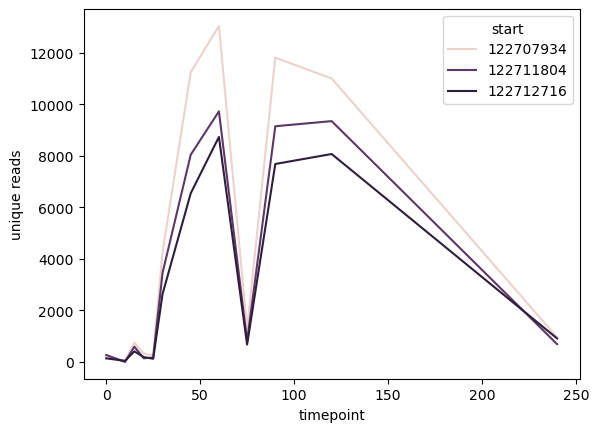

In [61]:
sns.lineplot(df_nanog, x='timepoint', y='unique reads', hue='start')

# Extract Annotations

Methods for extracting introns
1. Manual parsing of SAM files
2. STAR: SJ.out.tab
3. PySAM: find_introns()
4. rCube: createJunctionGRangesFromBam()
5. GenomicAlignments: junctions()

Analysis
- How many introns overlap (alternative splicing)
- How many introns are in GENCODE

## Chromosome Sizes

Used for `bedtools intersect -g <chrom_sizes.genome>`

In [9]:
file_mm10_sizes = os.path.join(dir_data, 'mm10.chrom.sizes')
file_mm10_nuclear_sizes = os.path.join(dir_data_aux, 'mm10.chrom_nuclear.sizes')

In [10]:
df_mm10_sizes = pd.read_csv(file_mm10_sizes, sep='\t', header=None, names=['chr', 'len'])

In [24]:
df_mm10_sizes.set_index('chr').squeeze()[mouse_chromosomes_nuclear].to_frame().reset_index().to_csv(
    file_mm10_nuclear_sizes, sep='\t', index=False, header=False)

## GENCODE annotations

Basic gene annotation: all entries except `gene` entries have `tag "basic"` in 9th GTF column

In [10]:
file_annot = os.path.join(dir_data, 'gencode.vM25.annotation.gtf.gz')
file_annot_basic = os.path.join(dir_data, 'gencode.vM25.basic.annotation.gtf.gz')
file_introns = os.path.join(dir_data_aux, 'gencode.vM25.introns.gtf.gz')

In [11]:
df_annot = pd.read_csv(file_annot, sep='\t', comment='#', names=columns_gtf) \
    .astype({
        'chr': 'category',
        'source': 'category',
        'feature type': 'category',
        'score': 'category',
        'strand': 'category',
        'phase': 'category'})
df_annot['gene_id'] = df_annot['additional'].str.extract(r'gene_id "([^"]+)"').squeeze()
df_annot['transcript_id'] = df_annot['additional'].str.extract(r'transcript_id "([^"]+)"').squeeze()

In [12]:
df_annot_basic = pd.read_csv(file_annot_basic, sep='\t', comment='#', names=columns_gtf) \
    .astype({
        'chr': 'category',
        'source': 'category',
        'feature type': 'category',
        'score': 'category',
        'strand': 'category',
        'phase': 'category'})
df_annot_basic['gene_id'] = df_annot_basic['additional'].str.extract(r'gene_id "([^"]+)"').squeeze()
df_annot_basic['transcript_id'] = df_annot_basic['additional'].str.extract(r'transcript_id "([^"]+)"').squeeze()

In [13]:
if not os.path.exists(file_introns):
    df_introns = utils_genomics.parse_gtf_to_introns(df_annot).astype({'start': int, 'end': int})
    df_introns[columns_gtf].to_csv(file_introns, sep='\t', index=False, header=False, quoting=csv.QUOTE_NONE)
else:
    df_introns = pd.read_csv(file_introns, sep='\t', comment='#', names=columns_gtf)
    df_introns['gene_id'] = df_introns['additional'].str.extract(r'gene_id "([^"]+)"').squeeze()
    df_introns['transcript_id'] = df_introns['additional'].str.extract(r'transcript_id "([^"]+)"').squeeze()

Note that each intron coordinate can appear multiple times (in different transcripts of the same or different genes)

In [14]:
df_introns_uniq = df_introns[['chr', 'start', 'end', 'strand']].drop_duplicates()

In [15]:
df_introns_basic = df_introns.loc[df_introns['additional'].str.contains('tag "basic"')]
df_introns_basic_uniq = df_introns_basic[['chr', 'start', 'end', 'strand']].drop_duplicates()

In [16]:
print(f'Unique transcript-intron pairs: {len(df_introns)}.')
print('Unique transcript-intron pairs in basic annotation: {}.'.format(
    len(df_introns.loc[df_introns['additional'].str.contains('tag "basic"')])))
print(f'Unique introns: {len(df_introns_uniq)}.')
print('Unique introns in basic annotation: {}.'.format(
    len(df_introns_basic[['chr', 'start', 'end', 'strand']].drop_duplicates())))

Unique transcript-intron pairs: 700798.
Unique transcript-intron pairs in basic annotation: 446191.
Unique introns: 285067.
Unique introns in basic annotation: 241606.


Note that transcripts from opposing strands can share the same intron coordinates.

In [17]:
df_introns.groupby(['chr', 'start', 'end']).filter(lambda df: len(df['strand'].unique()) > 1)

,chr,source,feature type,start,end,score,strand,phase,additional,gene_id,transcript_id
15740,chr11,HAVANA,intron,98804987,98809675,.,+,.,"gene_id ""ENSMUSG00000078676.9""; transcript_id ...",ENSMUSG00000078676.9,ENSMUST00000017384.13
38128,chr19,HAVANA,intron,28897603,28901441,.,+,.,"gene_id ""ENSMUSG00000024935.11""; transcript_id...",ENSMUSG00000024935.11,ENSMUST00000025875.4
38129,chr19,HAVANA,intron,28901627,28902685,.,+,.,"gene_id ""ENSMUSG00000024935.11""; transcript_id...",ENSMUSG00000024935.11,ENSMUST00000025875.4
38132,chr19,HAVANA,intron,28905528,28909430,.,+,.,"gene_id ""ENSMUSG00000024935.11""; transcript_id...",ENSMUSG00000024935.11,ENSMUST00000025875.4
38133,chr19,HAVANA,intron,28909566,28911653,.,+,.,"gene_id ""ENSMUSG00000024935.11""; transcript_id...",ENSMUSG00000024935.11,ENSMUST00000025875.4
...,...,...,...,...,...,...,...,...,...,...,...
692696,chr2,HAVANA,intron,174346058,174346241,.,+,.,"gene_id ""ENSMUSG00000027523.20""; transcript_id...",ENSMUSG00000027523.20,ENSMUST00000238318.1
694778,chr2,HAVANA,intron,174345302,174345382,.,+,.,"gene_id ""ENSMUSG00000027523.20""; transcript_id...",ENSMUSG00000027523.20,ENSMUST00000238660.1
694779,chr2,HAVANA,intron,174345563,174345648,.,+,.,"gene_id ""ENSMUSG00000027523.20""; transcript_id...",ENSMUSG00000027523.20,ENSMUST00000238660.1
694780,chr2,HAVANA,intron,174345780,174345989,.,+,.,"gene_id ""ENSMUSG00000027523.20""; transcript_id...",ENSMUSG00000027523.20,ENSMUST00000238660.1


### Statistics

Number of `transcript_support_level: "1"` annotated transcripts per gene: 0 to 25

In [18]:
dist_tsl1 = df_annot.loc[df_annot['feature type'] == 'transcript'] \
    .copy() \
    .pipe(lambda df: df.assign(tsl=df['additional'].str.extract(r'transcript_support_level "(\d+)"').squeeze())) \
    .pipe(lambda df: df[df['tsl'] == '1']) \
    .groupby('gene_id')['transcript_id'].count().value_counts()
dist_tsl1_basic = df_annot_basic.loc[df_annot_basic['feature type'] == 'transcript'] \
    .copy() \
    .pipe(lambda df: df.assign(tsl=df['additional'].str.extract(r'transcript_support_level "(\d+)"').squeeze())) \
    .pipe(lambda df: df[df['tsl'] == '1']) \
    .groupby('gene_id')['transcript_id'].count().value_counts()

In [19]:
pd.concat((dist_tsl1, dist_tsl1_basic), axis=1) \
    .set_axis(['Full', 'Basic'], axis='columns') \
    .sort_index() \
    .fillna(0) \
    .astype(int) \
    .rename_axis(index='Number of TSL1 transcripts per gene', columns='Annotation')

Annotation,Full,Basic
Number of TSL1 transcripts per gene,,
1,11424,14390
2,5160,4551
3,2716,1484
4,1346,522
5,717,183
6,355,70
7,167,27
8,71,16
9,37,7


Longest introns

In [339]:
with pd.option_context('max.colwidth', 1000):
    display(df_introns.loc[(df_introns['end'] - df_introns['start']) >= 1e6].drop(columns=['score', 'phase', 'gene_id', 'transcript_id']))

,chr,source,feature type,start,end,strand,additional
159385,chr5,HAVANA,intron,48509761,49524640,-,"gene_id ""ENSMUSG00000029088.16""; transcript_id ""ENSMUST00000087395.10""; gene_type ""protein_coding""; gene_name ""Kcnip4""; transcript_type ""protein_coding""; transcript_name ""Kcnip4-201""; level 2; protein_id ""ENSMUSP00000084656.4""; transcript_support_level ""5""; mgi_id ""MGI:1933131""; tag ""non_canonical_genome_sequence_error""; tag ""non_canonical_conserved""; tag ""basic""; tag ""appris_alternative_1""; tag ""CCDS""; ccdsid ""CCDS57342.1""; havana_gene ""OTTMUSG00000042185.5""; havana_transcript ""OTTMUST00000110740.2""; gene_length ""1135406""; transcript_start ""48389502""; transcript_end ""49524907""; transcript_strand ""-"";"
287869,chr7,HAVANA,intron,130172940,133081756,-,"gene_id ""ENSMUSG00000030849.18""; transcript_id ""ENSMUST00000124096.7""; gene_type ""protein_coding""; gene_name ""Fgfr2""; transcript_type ""protein_coding""; transcript_name ""Fgfr2-217""; level 2; protein_id ""ENSMUSP00000130971.1""; transcript_support_level ""5""; mgi_id ""MGI:95523""; tag ""basic""; havana_gene ""OTTMUSG00000031222.6""; havana_transcript ""OTTMUST00000094172.1""; gene_length ""2960900""; transcript_start ""130162451""; transcript_end ""133123350""; transcript_strand ""-"";"
302304,chr8,HAVANA,intron,119910940,124295357,+,"gene_id ""ENSMUSG00000092329.1""; transcript_id ""ENSMUST00000127664.1""; gene_type ""protein_coding""; gene_name ""Galnt2l""; transcript_type ""protein_coding""; transcript_name ""Galnt2l-201""; level 2; protein_id ""ENSMUSP00000118564.1""; transcript_support_level ""5""; mgi_id ""MGI:5141853""; tag ""basic""; tag ""appris_principal_1""; tag ""readthrough_transcript""; havana_gene ""OTTMUSG00000026145.5""; havana_transcript ""OTTMUST00000064647.3""; gene_length ""4434882""; transcript_start ""119910841""; transcript_end ""124345722""; transcript_strand ""+"";"
410155,chr3,HAVANA,intron,84540623,85785217,-,"gene_id ""ENSMUSG00000102805.5""; transcript_id ""ENSMUST00000154148.7""; gene_type ""protein_coding""; gene_name ""Gm37240""; transcript_type ""protein_coding""; transcript_name ""Gm37240-203""; level 2; protein_id ""ENSMUSP00000116393.1""; transcript_support_level ""1""; mgi_id ""MGI:5610468""; tag ""basic""; tag ""appris_principal_1""; tag ""readthrough_transcript""; havana_gene ""OTTMUSG00000032734.5""; havana_transcript ""OTTMUST00000081442.1""; gene_length ""1391091""; transcript_start ""84496426""; transcript_end ""85887516""; transcript_strand ""-"";"
492468,chr5,HAVANA,intron,48482656,49524640,-,"gene_id ""ENSMUSG00000029088.16""; transcript_id ""ENSMUST00000176191.7""; gene_type ""protein_coding""; gene_name ""Kcnip4""; transcript_type ""protein_coding""; transcript_name ""Kcnip4-207""; level 2; protein_id ""ENSMUSP00000135071.2""; transcript_support_level ""5""; mgi_id ""MGI:1933131""; tag ""basic""; tag ""CCDS""; ccdsid ""CCDS57341.1""; havana_gene ""OTTMUSG00000042185.5""; havana_transcript ""OTTMUST00000110744.2""; gene_length ""1135258""; transcript_start ""48389507""; transcript_end ""49524764""; transcript_strand ""-"";"
533916,chr16,HAVANA,intron,39984728,41206971,+,"gene_id ""ENSMUSG00000061080.11""; transcript_id ""ENSMUST00000189358.6""; gene_type ""protein_coding""; gene_name ""Lsamp""; transcript_type ""processed_transcript""; transcript_name ""Lsamp-208""; level 2; transcript_support_level ""5""; mgi_id ""MGI:1261760""; havana_gene ""OTTMUSG00000016989.4""; havana_transcript ""OTTMUST00000122268.1""; gene_length ""1225010""; transcript_start ""39984386""; transcript_end ""41209395""; transcript_strand ""+"";"


Shortest exon

In [20]:
df_annot.loc[df_annot['feature type'] == 'exon'].pipe(lambda df: df.loc[df['end'] - df['start'] < 10])

,chr,source,feature type,start,end,score,strand,phase,additional,gene_id,transcript_id
1129,chr1,HAVANA,exon,6262933,6262942,.,+,.,"gene_id ""ENSMUSG00000025907.14""; transcript_id...",ENSMUSG00000025907.14,ENSMUST00000159530.1
6025,chr1,HAVANA,exon,16643472,16643478,.,-,.,"gene_id ""ENSMUSG00000079658.9""; transcript_id ...",ENSMUSG00000079658.9,ENSMUST00000186701.1
7161,chr1,HAVANA,exon,21264843,21264846,.,+,.,"gene_id ""ENSMUSG00000025934.15""; transcript_id...",ENSMUSG00000025934.15,ENSMUST00000124990.2
7462,chr1,ENSEMBL,exon,22533796,22533796,.,-,.,"gene_id ""ENSMUSG00000041670.17""; transcript_id...",ENSMUSG00000041670.17,ENSMUST00000081544.12
7480,chr1,ENSEMBL,exon,22468100,22468109,.,-,.,"gene_id ""ENSMUSG00000041670.17""; transcript_id...",ENSMUSG00000041670.17,ENSMUST00000081544.12
...,...,...,...,...,...,...,...,...,...,...,...
1856356,chrX,ENSEMBL,exon,165004826,165004829,.,-,.,"gene_id ""ENSMUSG00000079600.2""; transcript_id ...",ENSMUSG00000079600.2,ENSMUST00000114890.2
1856359,chrX,ENSEMBL,exon,165004543,165004552,.,-,.,"gene_id ""ENSMUSG00000079600.2""; transcript_id ...",ENSMUSG00000079600.2,ENSMUST00000114890.2
1857417,chrX,HAVANA,exon,167475298,167475302,.,-,.,"gene_id ""ENSMUSG00000049176.16""; transcript_id...",ENSMUSG00000049176.16,ENSMUST00000239138.1
1866639,chrY,HAVANA,exon,54680976,54680980,.,+,.,"gene_id ""ENSMUSG00000096518.2""; transcript_id ...",ENSMUSG00000096518.2,ENSMUST00000179631.2


## STAR: SJ.out.tab

See [STAR manual](https://github.com/alexdobin/STAR/blob/master/doc/STARmanual.pdf) section 5.5

In [21]:
names_sjout = ['chr', 'start', 'end', 'strand', 'intron motif', 'annotated', 'unique reads', 'multi-mapping reads', 'overhang']
df_sj = []
for directory in directories_timecourse:
    df_sj.append(pd.read_csv(os.path.join(dir_data, 'fastqs', directory, 'SJ.out.tab'), sep='\t', header=None, names=names_sjout).assign(directory=directory))
df_sj = pd.concat(df_sj, axis=0)

Each intron coordinate is:
- only associated with a single strand across all timepoints
- only associated with a single intron motif (i.e., canonical / non-canonical, etc.) across all timepoints
- considered annotated or unannotated

In [22]:
assert len(df_sj.groupby(['chr', 'start', 'end']).filter(lambda df: len(df['strand'].unique()) > 1)) == 0
assert len(df_sj.groupby(['chr', 'start', 'end', 'strand']).filter(lambda df: len(df['intron motif'].unique()) > 1)) == 0
assert len(df_sj.groupby(['chr', 'start', 'end', 'strand']).filter(lambda df: len(df['annotated'].unique()) > 1)) == 0

In [23]:
df_sj_agg = df_sj.groupby(['chr', 'start', 'end', 'strand']).agg(
    **{'intron motif': ('intron motif', lambda x: np.unique(x)[0]),
       'annotated': ('annotated', lambda x: np.unique(x)[0]),
       'unique reads': ('unique reads', 'sum'),
       'multi-mapping reads': ('multi-mapping reads', 'sum'),
       'overhang': ('overhang', 'min'),
       'directories': ('directory', len)}).reset_index()

Filter introns
- At least 50 total reads (not even PCR/optically deduplicated) across all time points
- Defined strand (1 = +, 2 = -)
- Major chromosome

In [24]:
df_sj_filt = df_sj_agg.loc[
    df_sj_agg['strand'].isin((1, 2)) &
    (df_sj_agg['unique reads'] >= 50) &
    (df_sj_agg['chr'].str.match('chr(\d+|[XY])'))].copy()
df_sj_filt['strand'] = df_sj_filt['strand'].map({1: '+', 2: '-'})

Compare (merge) with GENCODE introns
- Because a given intron coordinate can be present multiple times in GENCODE (due to introns shared by different transcripts of the same or different genes), the number of introns with a `'both'` indicator exceeds the number of introns in `df_sj_filt`.

In [25]:
sj_merge_all = df_introns.merge(df_sj_filt, how='outer', indicator=True)
sj_merge_uniq = df_introns_uniq.merge(df_sj_filt, how='outer', indicator=True)

In [26]:
sj_merge_all_basic = df_introns_basic.merge(df_sj_filt, how='outer', indicator=True)
sj_merge_uniq_basic = df_introns_basic_uniq.merge(df_sj_filt, how='outer', indicator=True)

In [27]:
sj_merge_stats = pd.concat(
    (sj_merge_all['_merge'].value_counts(),
     sj_merge_uniq['_merge'].value_counts(),
     sj_merge_all_basic['_merge'].value_counts(),
     sj_merge_uniq_basic['_merge'].value_counts()),
    axis=1)
sj_merge_stats.columns = ['all', 'unique', 'all (basic)', 'unique (basic)']
sj_merge_stats.rename(index={'left_only': 'GENCODE', 'right_only': 'data (STAR)'}, inplace=True)
sj_merge_stats = sj_merge_stats.T
sj_merge_stats['fraction unannotated'] = sj_merge_stats['data (STAR)'] / (sj_merge_stats['GENCODE'] + sj_merge_stats['both'])
sj_merge_stats['coverage'] = sj_merge_stats['both'] / (sj_merge_stats['GENCODE'] + sj_merge_stats['both'])
sj_merge_stats

,GENCODE,both,data (STAR),fraction unannotated,coverage
all,496245,204553,559,0.000798,0.291886
unique,224904,60163,559,0.001961,0.211049
all (basic),320812,125379,1093,0.002450,0.280998
unique (basic),181977,59629,1093,0.004524,0.246803


## PySAM

### Without deduplication

In [255]:
pysam_introns_count_nodedup = {directory: {} for directory in directories_timecourse}
for directory in tqdm(directories_timecourse):
    with pysam.AlignmentFile(os.path.join(dir_data, 'fastqs', directory, f'aligned.MAPQ255STAR.mouse.bam'), 'rb') as samfile:
        for chrom in tqdm(mouse_chromosomes_nuclear):
            pysam_introns_count_nodedup[directory][chrom] = samfile.find_introns((read for read in samfile.fetch(contig=chrom)))

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

In [291]:
df_pysam_nodedup = pd.DataFrame(
    [(directory, chrom, start + 1, end, count)
        for directory, introns in pysam_introns_count_nodedup.items()
        for chrom, counts in introns.items()
        for (start, end), count in counts.items()],
    columns=['directory', 'chr', 'start', 'end', 'count'])

In [292]:
df_pysam_nodedup_agg = df_pysam_nodedup.groupby(['chr', 'start', 'end']).agg(
    **{'count': ('count', 'sum'),
       'directories': ('directory', len)}).reset_index()
df_pysam_nodedup_filt = df_pysam_nodedup_agg.loc[df_pysam_nodedup_agg['count'] >= 50]

In [293]:
pysam_nodedup_merge_all = df_introns.merge(df_pysam_nodedup_filt, how='outer', indicator=True)
pysam_nodedup_merge_uniq = df_introns_uniq.merge(df_pysam_nodedup_filt, how='outer', indicator=True)

In [294]:
pysam_nodedup_stats = pd.concat((pysam_nodedup_merge_all['_merge'].value_counts(), pysam_nodedup_merge_uniq['_merge'].value_counts()), axis=1)
pysam_nodedup_stats.columns = ['all', 'unique']
pysam_nodedup_stats = pysam_nodedup_stats.T
pysam_nodedup_stats['fraction unannotated'] = pysam_nodedup_stats['right_only'] / (pysam_nodedup_stats['left_only'] + pysam_nodedup_stats['both'])
pysam_nodedup_stats['coverage'] = pysam_nodedup_stats['both'] / (pysam_nodedup_stats['left_only'] + pysam_nodedup_stats['both'])
pysam_nodedup_stats

,left_only,both,right_only,fraction unannotated,coverage
all,296937,149254,2872,0.006437,0.334507
unique,170815,70791,2872,0.011887,0.293002


### Deduplicated

In [28]:
def pysam_find_introns(timepoint):
    introns = {}
    with pysam.AlignmentFile(os.path.join(dir_data_dedup, f'{timepoint}.MarkDuplicates.dedup.bam'), 'rb') as samfile:
        for chrom in tqdm(mouse_chromosomes_nuclear):
            introns[chrom] = samfile.find_introns((read for read in samfile.fetch(contig=chrom)))
            # If strandedness is desired:
            # introns[chrom] = {}
            # rev_strand_introns = samfile.find_introns((read for read in samfile.fetch(contig=chrom) if read.is_reverse))
            # rev_strand_introns = {(start, stop, '-'): count for (start, stop), count in rev_strand_introns.items()}
            # fwd_strand_introns = samfile.find_introns((read for read in samfile.fetch(contig=chrom) if not read.is_reverse))
            # fwd_strand_introns = {(start, stop, '+'): count for (start, stop), count in fwd_strand_introns.items()}
            # introns[chrom].update(rev_strand_introns)
            # introns[chrom].update(fwd_strand_introns)
    return introns

In [29]:
file_pysam_introns = os.path.join(dir_data_aux, 'pysam_introns.csv.gz')

In [30]:
if not os.path.exists(file_pysam_introns):
    with concurrent.futures.ThreadPoolExecutor(max_workers=len(timepoints)) as executor:
        pysam_introns = executor.map(pysam_find_introns, timepoints)
    # pysam_introns = {timepoint: v for timepoint, v in zip(timepoints, pysam_introns)}
    df_pysam = pd.DataFrame(
        [(timepoint, chrom, start + 1, end, count)
            for timepoint, introns in zip(timepoints, pysam_introns)
            for chrom, counts in introns.items()
            for (start, end), count in counts.items()],
        columns=['timepoint', 'chr', 'start', 'end', 'count'])

    # pysam_introns = {timepoint: {} for timepoint in timepoints}
    # for timepoint in tqdm(timepoints):
    #     with pysam.AlignmentFile(os.path.join(dir_data_dedup, f'{timepoint}.MarkDuplicates.dedup.bam'), 'rb') as samfile:
    #         for chrom in tqdm(mouse_chromosomes_nuclear):
    #             pysam_introns[timepoint][chrom] = samfile.find_introns((read for read in samfile.fetch(contig=chrom)))
    df_pysam.to_csv(file_pysam_introns, sep=',', header=True, index=False)
else:
    df_pysam = pd.read_csv(file_pysam_introns)

In [31]:
df_pysam_agg = df_pysam.groupby(['chr', 'start', 'end']).agg(
    **{'count': ('count', 'sum'),
       'timepoints': ('timepoint', len)}).reset_index()
df_pysam_filt = df_pysam_agg.loc[df_pysam_agg['count'] >= 50]

In [32]:
pysam_merge_all = df_introns.merge(df_pysam_filt, how='outer', indicator=True)
pysam_merge_uniq = df_introns_uniq.merge(df_pysam_filt, how='outer', indicator=True)
pysam_merge_all_basic = df_introns_basic.merge(df_pysam_filt, how='outer', indicator=True)
pysam_merge_uniq_basic = df_introns_basic_uniq.merge(df_pysam_filt, how='outer', indicator=True)

In [33]:
pysam_stats = pd.concat(
    (pysam_merge_all['_merge'].value_counts(),
     pysam_merge_uniq['_merge'].value_counts(),
     pysam_merge_all_basic['_merge'].value_counts(),
     pysam_merge_uniq_basic['_merge'].value_counts()),
    axis=1)
pysam_stats.columns = ['all', 'unique', 'all (basic)', 'unique (basic)']
pysam_stats.rename(index={'left_only': 'GENCODE', 'right_only': 'data (PySAM)'}, inplace=True)
pysam_stats = pysam_stats.T
pysam_stats['fraction unannotated'] = pysam_stats['data (PySAM)'] / (pysam_stats['GENCODE'] + pysam_stats['both'])
pysam_stats['coverage'] = pysam_stats['both'] / (pysam_stats['GENCODE'] + pysam_stats['both'])
pysam_stats

,GENCODE,both,data (PySAM),fraction unannotated,coverage
all,490015,210783,1038,0.001481,0.300776
unique,223059,62008,1038,0.003641,0.217521
all (basic),316903,129288,1625,0.003642,0.289759
unique (basic),180185,61421,1625,0.006726,0.254220


#### What genes do the unannotated introns overlap?

- 154 out of the 1038 unannotated introns do not overlap a gene.
- 1986 genes overlap an unannotated intron.

In [34]:
df_genes = df_annot.loc[df_annot['feature type'] == 'gene'].copy() \
    .pipe(lambda df: df.assign(gene_name=df['additional'].str.extract(r'gene_name "([^"]+)"'))) \
    [['chr', 'start', 'end', 'strand', 'gene_id', 'gene_name']]
gene_id_to_gene_name = df_genes.set_index('gene_id')['gene_name'].to_dict()

In [35]:
unannotated_introns_pysam = pysam_merge_uniq.loc[pysam_merge_uniq['_merge'] == 'right_only'].copy()
unannotated_introns_pysam['overlapping gene_ids'] = unannotated_introns_pysam.apply(
    lambda s: ';'.join(df_genes.loc[(df_genes['chr'] == s['chr']) & (df_genes['end'] >= s['start']) & (df_genes['start'] <= s['end']), 'gene_id'].to_list()),
    axis=1)
unannotated_introns_pysam['overlapping gene_names'] = unannotated_introns_pysam['overlapping gene_ids'].map(
    lambda s: ';'.join((gene_id_to_gene_name[gene_id] for gene_id in s.split(';') if gene_id != '')))

In [36]:
pd.Series(collections.Counter(';'.join(unannotated_introns_pysam['overlapping gene_ids'].to_list()).split(';'))) \
    .sort_values() \
    .to_frame() \
    .reset_index() \
    .rename(columns={'index': 'gene_id', 0: 'number of overlapping unannotated introns'}) \
    .merge(df_genes, how='left')

,gene_id,number of overlapping unannotated introns,chr,start,end,strand,gene_name
0,ENSMUSG00000033813.15,1,chr1,4857814.0,4897909.0,+,Tcea1
1,ENSMUSG00000003779.16,1,chr18,34624613.0,34633277.0,+,Kif20a
2,ENSMUSG00000109241.1,1,chr8,4391726.0,4392133.0,+,Gm7434
3,ENSMUSG00000033382.15,1,chr18,20817223.0,20896093.0,-,Trappc8
4,ENSMUSG00000037013.17,1,chr18,14624198.0,14682914.0,-,Ss18
...,...,...,...,...,...,...,...
1982,ENSMUSG00000043336.14,26,chr16,57353093.0,57573126.0,+,Filip1l
1983,ENSMUSG00000022748.8,26,chr16,57302000.0,57606864.0,-,Cmss1
1984,ENSMUSG00000117319.1,29,chr17,39811786.0,39812022.0,-,Gm49833
1985,ENSMUSG00000106106.3,87,chr17,39846353.0,39848201.0,+,CT010467.1


In [37]:
unannotated_introns_pysam.loc[unannotated_introns_pysam['overlapping gene_ids'] == '']

,chr,start,end,strand,count,timepoints,_merge,overlapping gene_ids,overlapping gene_names
285069,chr1,11386244,11386788,NaN,83.0,9.0,right_only,,
285070,chr1,11386886,11395382,NaN,51.0,8.0,right_only,,
285142,chr11,88968187,88968211,NaN,323.0,12.0,right_only,,
285146,chr11,97662654,97662757,NaN,54.0,9.0,right_only,,
285171,chr11,109011709,109011785,NaN,156.0,12.0,right_only,,
...,...,...,...,...,...,...,...,...,...
286079,chrY,90735098,90735651,NaN,175.0,12.0,right_only,,
286080,chrY,90735136,90735151,NaN,346.0,12.0,right_only,,
286081,chrY,90735180,90735337,NaN,339.0,12.0,right_only,,
286084,chrY,90741564,90741829,NaN,69.0,10.0,right_only,,


# Filter GENCODE annotations

## Single Isoform Single Intron Non-overlapping Genes

1989 in GENCODE, 70 of which are supported by our data

In [15]:
file_single_isoform_single_intron = os.path.join(dir_data_aux, 'single_isoform_single_intron.gff')

### GENCODE filters

- annotated mgi_id, gene_id, and gene_name
- only 1 transcript at (transcript_support_level: 1) for that gene
- that transcript has only 1 intron
- that transcript does not overlap any other transcripts with (transcript_support_level: 1)

In [161]:
df_introns_filt = df_introns \
    .assign(gene_id=df_introns['additional'].str.extract(r'gene_id "([^"]+)"').squeeze(),
            tsl=df_introns['additional'].str.extract(r'transcript_support_level "(\d+)"').squeeze(),
            gene_name=df_introns['additional'].str.extract(r'gene_name "([^"]+)"'),
            mgi_id=df_introns['additional'].str.extract(r'mgi_id "([^"]+)"'),
            transcript_id=df_introns['additional'].str.extract(r'transcript_id "([^"]+)"')) \
    .dropna(how='any', subset=['gene_id', 'tsl', 'gene_name', 'mgi_id']) \
    .astype(dict(tsl=int)) \
    .pipe(lambda df: df.loc[df['tsl'] == 1])

In [162]:
df_transcripts_tsl1 = df_annot \
    .loc[(df_annot['feature type'] == 'transcript') &
         (df_annot['chr'].isin(mouse_chromosomes_nuclear))].copy()
df_transcripts_tsl1 = df_transcripts_tsl1 \
    .assign(
        gene_id=df_transcripts_tsl1['additional'].str.extract(r'gene_id "([^"]+)"').squeeze(),
        gene_name=df_transcripts_tsl1['additional'].str.extract(r'gene_name "([^"]+)"'),
        mgi_id=df_transcripts_tsl1['additional'].str.extract(r'mgi_id "([^"]+)"'),
        tsl=df_transcripts_tsl1['additional'].str.extract(r'transcript_support_level "(\d+)"').squeeze(),
        transcript_id=df_transcripts_tsl1['additional'].str.extract(r'transcript_id "([^"]+)"')) \
    .pipe(lambda df: df.loc[df['tsl'] == '1']) \
    .astype(dict(tsl=int))

In [163]:
df_introns_single = df_introns_filt \
    .groupby('gene_id').filter(lambda df: len(df) == 1) \
    .merge(
        df_transcripts_tsl1[['start', 'end', 'transcript_id']].rename(columns=dict(start='transcript_start', end='transcript_end')),
        how='left') \
    .reset_index(drop=True)

In [164]:
df_transcripts_tsl1_single_isoform = df_transcripts_tsl1.groupby('gene_id').filter(lambda df: len(df) == 1)

In [165]:
df_transcripts_tsl1_single_isoform_single_intron = df_transcripts_tsl1_single_isoform.loc[
    df_transcripts_tsl1_single_isoform['transcript_id'].isin(set(df_introns_single['transcript_id']))].copy()

In [166]:
df_transcripts_tsl1_single_isoform_single_intron_nonoverlapping = []
for _, row in df_transcripts_tsl1_single_isoform_single_intron.iterrows():
    df_overlap = df_transcripts_tsl1.loc[
        (df_transcripts_tsl1['chr'] == row['chr']) &
        ((df_transcripts_tsl1['start'] <= row['end']) & (df_transcripts_tsl1['end'] >= row['start'])) &
        (df_transcripts_tsl1['transcript_id'] != row['transcript_id'])]
    if len(df_overlap) == 0:
        df_transcripts_tsl1_single_isoform_single_intron_nonoverlapping.append(row)
df_transcripts_tsl1_single_isoform_single_intron_nonoverlapping = \
    pd.concat(df_transcripts_tsl1_single_isoform_single_intron_nonoverlapping, axis=1).T \
    .reset_index(drop=True) \
    .infer_objects()

In [167]:
df_transcripts_tsl1_single_isoform_single_intron_nonoverlapping = \
    df_transcripts_tsl1_single_isoform_single_intron_nonoverlapping.merge(
        df_introns_single[['chr', 'start', 'end', 'transcript_id']].rename(columns=dict(start='intron_start', end='intron_end')),
        how='left',
        indicator=True)
assert (df_transcripts_tsl1_single_isoform_single_intron_nonoverlapping['_merge'] == 'both').all()
df_transcripts_tsl1_single_isoform_single_intron_nonoverlapping.drop(columns='_merge', inplace=True)

In [55]:
df_transcripts_tsl1_single_isoform_single_intron_nonoverlapping['chr'].value_counts()

chrY     151
chr2     150
chr8     139
chr11    131
chr3     125
chr4     122
chr7     121
chr1     116
chr5     108
chr6      98
chrX      95
chr9      92
chr13     86
chr10     83
chr12     83
chr14     64
chr17     55
chr15     48
chr19     47
chr16     42
chr18     33
Name: chr, dtype: int64

### Data filters

- GENCODE-filtered transcripts that overlap only 1 non-spurious (total count > 2, timepoints > 1) data intron
- GENCODE-filtered transcripts supported by 10+ data intron counts across 2+ time points

Check for potential spurious introns in data

In [171]:
df_pysam_agg['count'].value_counts()

1       131104
2       101605
3        15687
4        13553
5         7316
         ...  
2770         1
1417         1
5163         1
4152         1
4245         1
Name: count, Length: 2395, dtype: int64

In [172]:
df_pysam_agg.loc[df_pysam_agg['count'] > 2, 'timepoints'].value_counts()

2     23697
3     17427
9     14705
8     14680
10    14090
7     13722
12    13699
11    13433
4     12838
6     12478
5     11599
1      3574
Name: timepoints, dtype: int64

In [173]:
df_data_introns_nonspurious = df_pysam_agg.loc[
    (df_pysam_agg['count'] > 2) & (df_pysam_agg['timepoints'] > 1)].reset_index()

In [174]:
df_transcripts_tsl1_single_isoform_single_intron_nonoverlapping_indata = []
for _, row in df_transcripts_tsl1_single_isoform_single_intron_nonoverlapping.iterrows():
    df_overlap = df_data_introns_nonspurious.loc[
        (df_data_introns_nonspurious['chr'] == row['chr']) &
        ((df_data_introns_nonspurious['start'] <= row['end']) & (df_data_introns_nonspurious['end'] >= row['start']))]
    if len(df_overlap) > 1:
        continue
    s_intron = df_data_introns_nonspurious.loc[
        (df_data_introns_nonspurious['chr'] == row['chr']) &
        (df_data_introns_nonspurious['start'] == row['intron_start']) & 
        (df_data_introns_nonspurious['end'] == row['intron_end']),
        'count']
    if len(s_intron) == 1 and s_intron.item() >= 10:
        row = row.copy()
        row['count'] = s_intron.item()
        df_transcripts_tsl1_single_isoform_single_intron_nonoverlapping_indata.append(row)
df_transcripts_tsl1_single_isoform_single_intron_nonoverlapping_indata = pd.concat(
    df_transcripts_tsl1_single_isoform_single_intron_nonoverlapping_indata, axis=1).T \
    .reset_index(drop=True) \
    .pipe(lambda df: df.assign(transcript_type=df['additional'].str.extract('transcript_type "([^"]+)"').squeeze())) \
    .infer_objects()

In [175]:
df_transcripts_tsl1_single_isoform_single_intron_nonoverlapping_indata

,chr,source,feature type,start,end,score,strand,phase,additional,gene_id,gene_name,mgi_id,tsl,transcript_id,intron_start,intron_end,count,transcript_type
0,chr1,HAVANA,transcript,90203980,90216751,.,+,.,"gene_id ""ENSMUSG00000044337.5""; transcript_id ...",ENSMUSG00000044337.5,Ackr3,MGI:109562,1,ENSMUST00000065587.4,90204088,90213794,250,protein_coding
1,chr1,HAVANA,transcript,119907890,119913208,.,-,.,"gene_id ""ENSMUSG00000036975.5""; transcript_id ...",ENSMUSG00000036975.5,Tmem177,MGI:1913593,1,ENSMUST00000037906.5,119911155,119913132,42,protein_coding
2,chr1,HAVANA,transcript,120067377,120074074,.,-,.,"gene_id ""ENSMUSG00000050777.7""; transcript_id ...",ENSMUSG00000050777.7,Tmem37,MGI:2157899,1,ENSMUST00000056089.7,120068325,120073711,14,protein_coding
3,chr1,HAVANA,transcript,134075170,134079120,.,-,.,"gene_id ""ENSMUSG00000020423.6""; transcript_id ...",ENSMUSG00000020423.6,Btg2,MGI:108384,1,ENSMUST00000020692.6,134077704,134078911,287,protein_coding
4,chr1,HAVANA,transcript,184871926,184883218,.,-,.,"gene_id ""ENSMUSG00000039349.5""; transcript_id ...",ENSMUSG00000039349.5,C130074G19Rik,MGI:2444831,1,ENSMUST00000048308.5,184874428,184882685,16,protein_coding
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,chrX,HAVANA,transcript,6047453,6055110,.,+,.,"gene_id ""ENSMUSG00000073295.4""; transcript_id ...",ENSMUSG00000073295.4,Nudt11,MGI:1930957,1,ENSMUST00000103007.3,6048405,6053026,46,protein_coding
72,chrX,ENSEMBL,transcript,58911461,58920304,.,+,.,"gene_id ""ENSMUSG00000046180.11""; transcript_id...",ENSMUSG00000046180.11,4930550L24Rik,MGI:1922602,1,ENSMUST00000062542.4,58911562,58918833,161,protein_coding
73,chrX,HAVANA,transcript,95420318,95444872,.,-,.,"gene_id ""ENSMUSG00000050332.7""; transcript_id ...",ENSMUSG00000050332.7,Amer1,MGI:1919595,1,ENSMUST00000084535.5,95428599,95444657,44,protein_coding
74,chrX,HAVANA,transcript,134537256,134541865,.,-,.,"gene_id ""ENSMUSG00000048007.4""; transcript_id ...",ENSMUSG00000048007.4,Timm8a1,MGI:1353433,1,ENSMUST00000054213.4,134538268,134541456,750,protein_coding


In [25]:
def df_to_gff3(df):
    gff3 = []
    for _, row in df.iterrows():
        attributes = ';'.join([
            f'gene_id={row["gene_id"]}', # f'Dbxref="ENSEMBL_GeneID:{row["gene_id"]}"',
            f'transcript_id={row["transcript_id"]}', # f'Dbxref="ENSEMBL_TranscriptID:{row["transcript_id"]}"',
            f'mgi_id={row["mgi_id"]}', # f'Dbxref="MGI:{row["mgi_id"]}"',
            f'gene_name={row["gene_name"]}', # f'Name={row["gene_name"]}',
            f'transcript_type:{row["transcript_type"]}' # f'Transcript_Type:{row["transcript_type"]}'
        ])
        exon1 = row.copy()
        exon2 = row.copy()
        intron = row.copy()
        exon1['end'] = row['intron_start'] - 1
        exon2['start'] = row['intron_end'] + 1
        intron['start'] = intron['intron_start']
        intron['end'] = intron['intron_end']
        exon1['feature type'] = 'exon'
        exon2['feature type'] = 'exon'
        intron['feature type'] = 'intron'
        exon1['attributes'] = attributes
        exon2['attributes'] = attributes
        intron['attributes'] = attributes
        for series in (exon1, exon2, intron):
            gff3.append(series[columns_gff3])
    gff3 = pd.concat(gff3, axis=1).T.reset_index(drop=True).infer_objects()
    return gff3

In [26]:
if not os.path.exists(file_single_isoform_single_intron):
    gff3_single_isoform_single_intron = df_to_gff3(
        df_transcripts_tsl1_single_isoform_single_intron_nonoverlapping_indata) \
        .astype({'chr': 'category'}) \
        .pipe(lambda df: df.assign(chr=df['chr'].cat.set_categories(new_categories=mouse_chromosomes_nuclear, ordered=True))) \
        .sort_values(['chr', 'start', 'end']) \
        .reset_index(drop=True) \
        .pipe(lambda df: df.assign(attributes='ID=' + df.index.astype(str) + ';' + df['attributes']))
    with open(file_single_isoform_single_intron, 'wt') as f:
        f.write('##gff-version 3\n')
        gff3_single_isoform_single_intron.to_csv(
            f,
            sep='\t',
            header=False,
            index=False,
            quoting=csv.QUOTE_NONE)
else:
    gff3_single_isoform_single_intron = pd.read_csv(file_single_isoform_single_intron, sep='\t', header=None, comment='#', names=columns_gff3) \
        .astype({'chr': 'category'}) \
        .pipe(lambda df: df.assign(chr=df['chr'].cat.set_categories(new_categories=mouse_chromosomes_nuclear, ordered=True)))

## Single TSS Non-Overlapping Genes

Notes
- Implementation below not strictly single-isoform per gene, but rather single-TSS per gene.
- Current implementation excludes single-exon genes

Filtering steps

1. (43803) `transcript_status_level` 1
2. (7071) TSL1 data-supported transcript: >=50 reads (total, over all timepoints) at each junction
3. (3796) TSL1 data-restricted transcripts: exons do not overlap any data introns (>=50 reads total over all timepoints)
   - Some genes have multiple transcripts with identical introns (but different exons) and/or are "supersets" of one another (e.g., transcript A = [exon + intron +] transcript B [+ intron + exon])
4. (3687) TSL1 data-restricted single TSS genes: transcripts corresponding to the same gene have the same TSS
5. (3603) TSL1 data-restricted single TSS non-overlapping genes: transcripts do not overlap transcripts from other genes

Alternatives
- Potential alternative for Step 3: Alternatively, >=90% reads overlapping the gene fall within the transcript boundaries, and the number of data intron reads overlapping the transcript exons is < 10% of the smallest number of data intron reads supporting any transcript intron.
- Check overlap not just to other TSL1 data-restricted single TSS genes, but to (paired-end) reads that extend beyond transcript boundaries
  - Use `bedtools bamtobed -bedpe` to convert paired-end reads into a single BED file of known fragment boundaries

    ```{bash}
    samtools sort -n <bamfile> |
        bedtools bamtobed -i /dev/stdin |
        awk 'BEGIN {FS = "\t"; OFS = "\t"} {
            if ($4 = ".") { # unpaired read
                start = ($1 < $2) ? $1 : $2
                end = ($1 < $2) ? $2 : $1
            } else { # paired read
                n = split("$2 $3 $5 $6", positions)
                start = $2
                end = $2
                for (i=2; i<=n; i++) {
                    if (positions[i] < start) start = positions[i]
                    if (positions[i] > end) end = positions[i]
                }
            }
            print $1, start, end
        }'
    ```
    
  - Then overlap those reads with boundaries of transcripts
    
    ```{python}
    # create BED file of transcript boundaries
    # for each transcript, generate 2 BED entries:
    # 1. The nucleotide immediately before the TSS to the TSS itself
    # 2. The TES nucleotide and the nucleotide immediately after
    ```
    
    ```{bash}
    bedtools intersect -c -f 1 -a <transcript boundaries> -b <fragment boundaries>
    ```

In [90]:
file_singleTSS_nonoverlapping_transcripts = os.path.join(dir_data_aux, 'single_TSS_transcripts.gtf.gz')

In [39]:
transcript_ids_tsl1 = set(df_annot.loc[df_annot['feature type'] == 'transcript'] \
    .pipe(lambda df: df.assign(tsl=df['additional'].str.extract(r'transcript_support_level "(\d+)"').squeeze())) \
    .dropna(subset='tsl') \
    .astype(dict(tsl=int)) \
    .pipe(lambda df: df.loc[df['tsl'] == 1]) \
    ['transcript_id'])

In [40]:
df_tsl1_data_supported = df_introns \
    .loc[df_introns['transcript_id'].isin(transcript_ids_tsl1)] \
    .merge(df_pysam_filt, how='left', indicator=True) \
    .groupby('transcript_id') \
    .filter(lambda df: (df['_merge'] == 'both').all())

In [41]:
transcript_ids_tsl1_data_supported = set(df_tsl1_data_supported['transcript_id'])

In [51]:
def per_chr_intron_overlap(group):
    chrom = group.name
    data_introns = df_pysam_filt.loc[df_pysam_filt['chr'] == chrom]
    mat = (group['start'].values.reshape(-1, 1) <= data_introns['end'].values.reshape(1, -1)) & \
          (group['end'].values.reshape(-1, 1) >= data_introns['start'].values.reshape(1, -1))
    return pd.Series(mat.any(axis=1), name=chrom, index=group.index)

df_tsl1_data_restricted = df_annot.loc[
    (df_annot['feature type'] == 'exon') &
    df_annot['transcript_id'].isin(transcript_ids_tsl1_data_supported)].copy()
df_tsl1_data_restricted['overlap_intron'] = df_tsl1_data_restricted \
    .groupby('chr', group_keys=False) \
    .apply(per_chr_intron_overlap)
df_tsl1_data_restricted = df_tsl1_data_restricted \
    .groupby('transcript_id') \
    .filter(lambda df: ~(df['overlap_intron'].any()))

# Alternative code: more memory efficient but much slower
# df_tsl1_data_restricted = df_annot \
#     .loc[(df_annot['feature type'] == 'exon') & df_annot['transcript_id'].isin(transcript_ids_tsl1_indata)] \
#     .pipe(lambda df: df.assign(
#         overlap_intron=df.apply(
#             lambda s: ((s['chr'] == df_pysam_filt['chr']) & (s['start'] <= df_pysam_filt['end']) & (s['end'] >= df_pysam_filt['start'])).any(),
#             axis=1))) \
#     .groupby('transcript_id') \
#     .filter(lambda df: ~(df['overlap_intron'].any()))

In [53]:
transcript_ids_tsl1_data_restricted = set(df_tsl1_data_restricted['transcript_id'])

In [471]:
df_transcripts = df_annot \
    .loc[df_annot['feature type'] == 'transcript'] \
    .drop(columns=['score', 'phase']) \
    .pipe(lambda df: df.assign(gene_id=df['additional'].str.extract(r'gene_id "([^"]+)"').squeeze(),
                               transcript_id=df['additional'].str.extract(r'transcript_id "([^"]+)"').squeeze()))

In [56]:
def same_TSS(df):
    if len(df['transcript_id'].unique()) == 1:
        return True
    gene_id = df['gene_id'].unique()[0]
    df = df[['gene_id', 'transcript_id']].merge(df_annot.loc[df_annot['feature type'] == 'transcript'], how='left')
    strand = df['strand'].unique()
    assert len(strand) == 1
    strand = strand[0]
    if strand == '+':
        return len(df['start'].unique()) == 1
    else:
        return len(df['end'].unique()) == 1

df_tsl1_data_restricted_singleTSS = df_tsl1_data_restricted.groupby('gene_id').filter(same_TSS)
transcript_ids_tsl1_data_restricted_singleTSS = set(df_tsl1_data_restricted_singleTSS['transcript_id'])

In [66]:
def nonoverlapping_transcripts(df):
    nonoverlapping_idxs = []
    for i, row in tqdm(df.iterrows(), total=len(df)):
        df_othergenes = df.loc[df['gene_id'] != row['gene_id']]
        overlap = ((row['chr'] == df_othergenes['chr']) & (row['start'] <= df_othergenes['end']) & (row['end'] >= df_othergenes['start'])).any()
        if not overlap:
            nonoverlapping_idxs.append(i)
    return df.loc[nonoverlapping_idxs]
        
df_singleTSS_nonoverlapping_transcripts = df_annot \
    .loc[(df_annot['feature type'] == 'transcript') & 
         df_annot['transcript_id'].isin(transcript_ids_tsl1_data_restricted_singleTSS)] \
    .reset_index(drop=True) \
    .pipe(nonoverlapping_transcripts)
transcript_ids_singleTSS_nonoverlapping_transcripts = df_singleTSS_nonoverlapping_transcripts['transcript_id']

  0%|          | 0/3687 [00:00<?, ?it/s]

In [91]:
df_singleTSS_nonoverlapping_transcripts[columns_gtf] \
    .to_csv(file_singleTSS_nonoverlapping_transcripts, sep='\t', index=False, header=False, quoting=csv.QUOTE_NONE)

### Analysis of Single TSS Non-Overlapping Genes

Transcript biotypes

In [169]:
df_annot \
    .loc[(df_annot['feature type'] == 'transcript') &
         df_annot['transcript_id'].isin(transcript_ids_singleTSS_nonoverlapping_transcripts)] \
    .pipe(lambda df: df.assign(transcript_type=df['additional'].str.extract(r'transcript_type "([^"]+)"').squeeze())) \
    ['transcript_type'].value_counts()

protein_coding                   3442
retained_intron                   106
processed_transcript               25
nonsense_mediated_decay            11
lincRNA                            10
antisense                           8
bidirectional_promoter_lncRNA       1
Name: transcript_type, dtype: int64

Number of introns

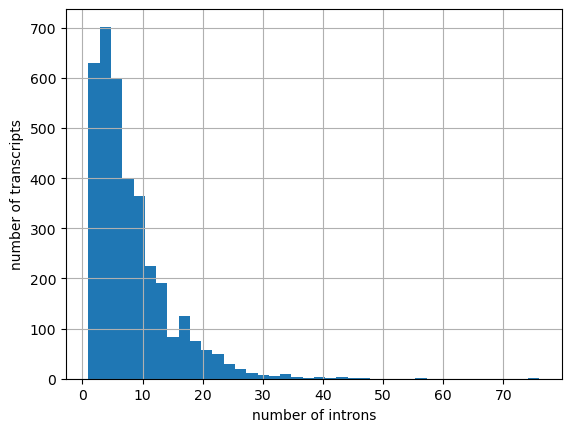

In [183]:
fig, ax = plt.subplots()
df_introns \
    .loc[df_introns['transcript_id'].isin(transcript_ids_singleTSS_nonoverlapping_transcripts)] \
    .groupby('transcript_id').apply(len).hist(bins=40, ax=ax)
ax.set(xlabel='number of introns', ylabel='number of transcripts')
fig.show()

## Unambiguous Annotated Junctions

Reads extending into the intron or reads spanning the junction all correspond to only 1 possible TSS
- Not alternatively spliced
- Not overlapping any other genes

# Compute counts at each junction from data

In [98]:
def fill_missing_timepoints(df, timepoints=timepoints):
    assert len(df[['chr', 'start', 'end', 'strand']].drop_duplicates()) == 1
    missing_timepoints = set(timepoints) - set(df['timepoint'])
    if len(missing_timepoints) == 0:
        return df
    new_rows = []
    for timepoint in missing_timepoints:
        row = df.iloc[0, :].copy()
        row.update(dict(timepoint=timepoint, count=0, count_norm=0))
        new_rows.append(row)
    return pd.concat(
        (df, 
         pd.concat(new_rows, axis=1, ignore_index=True).T),
        axis=0,
        ignore_index=True)

## Normalization

In [93]:
df_library_complexity = pd.read_excel(os.path.join(dir_data, 'moleculecount.xlsx'))
df_library_complexity['timepoint'] = df_library_complexity['Sample'] \
    .str.extract(r'5EU \+ (\d+) min').astype(int)

In [94]:
df_library_depth = pd.read_csv(
    os.path.join(dir_data_aux, 'dedup.count'),
    sep='\s+',
    header=None,
    names=['filename', 'n_reads']) \
    .pipe(lambda df: df.assign(timepoint=df['filename'].map(lambda s: int(s.split('.')[0]))))

In [95]:
df_normalization = df_library_depth[['timepoint', 'n_reads']].merge(
    df_library_complexity.rename(columns={'Molecules pre-PCR': 'n_unique_molecules'}) \
        [['n_unique_molecules', 'timepoint']])
df_normalization['denom'] = df_normalization['n_reads'] / df_normalization['n_unique_molecules']

<AxesSubplot: xlabel='timepoint', ylabel='denom'>

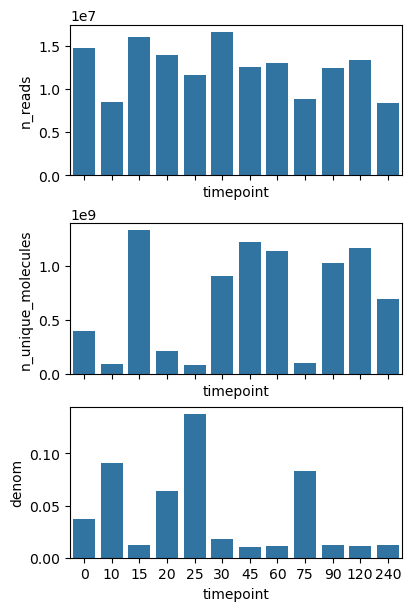

In [135]:
fig, axs = plt.subplots(3, 1, figsize=(4, 6), constrained_layout=True, sharex=True)
sns.barplot(df_normalization, x='timepoint', y='n_reads', color='C0', ax=axs[0])
sns.barplot(df_normalization, x='timepoint', y='n_unique_molecules', color='C0', ax=axs[1])
sns.barplot(df_normalization, x='timepoint', y='denom', color='C0', ax=axs[2])

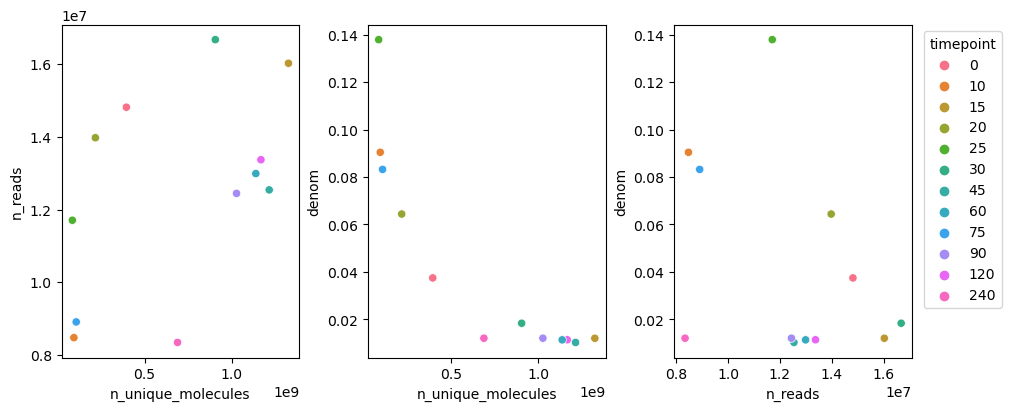

In [153]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4), constrained_layout=True)
sns.scatterplot(df_normalization.astype(dict(timepoint='category')), x='n_unique_molecules', y='n_reads', hue='timepoint', legend=False, ax=axs[0])
sns.scatterplot(df_normalization.astype(dict(timepoint='category')), x='n_unique_molecules', y='denom', hue='timepoint', legend=False, ax=axs[1])
sns.scatterplot(df_normalization.astype(dict(timepoint='category')), x='n_reads', y='denom', hue='timepoint', ax=axs[2])
axs[2].legend(bbox_to_anchor=(1.02, 1.0), loc='upper left', title='timepoint')

In [157]:
read_length = 151

## Single Isoform Single Intron Non-overlapping Genes

In [149]:
%%bash -s {dir_data_dedup} {dir_data_aux} {file_single_isoform_single_intron} {file_mm10_nuclear_sizes}
set -e -o pipefail

source ~/.bashrc

dir_data_dedup="$1"
dir_data_aux="$2"
path_single_isoform_single_intron="$3"
path_mm10_nuclear_sizes="$4"

dir_counts="${dir_data_aux}/single_isoform_single_intron_counts"
mkdir -p "$dir_counts"

for path_dedup_bam in "$dir_data_dedup"/*.MarkDuplicates.dedup.bam; do
    file_dedup_bam="$(basename $path_dedup_bam)"
    timepoint="${file_dedup_bam%%.*}"
    file_out="${dir_counts}/${timepoint}.counts"
    bedtools intersect \
        -c \
        -sorted \
        -g "$path_mm10_nuclear_sizes" \
        -a "$path_single_isoform_single_intron" \
        -b "$path_dedup_bam" > "$file_out" &
done
wait

In [158]:
df_single_isoform_single_intron_counts = []
for timepoint in timepoints:
    file_counts = os.path.join(dir_data_aux, 'single_isoform_single_intron_counts', f'{timepoint}.counts')
    df_single_isoform_single_intron_counts.append(
        pd.read_csv(file_counts, sep='\t', header=None, comment='#', names=columns_gff3 + ['count']) \
        .assign(timepoint=timepoint))
df_single_isoform_single_intron_counts_norm = pd.concat(
    df_single_isoform_single_intron_counts,
    axis=0,
    ignore_index=True) \
    .pipe(lambda df: df.assign(transcript_id=df['attributes'].str.extract('transcript_id=([^;]+)'))) \
    .merge(df_normalization[['timepoint', 'denom']], how='left') \
    .pipe(lambda df: df.assign(count_norm=df['count'] / df['denom'] / (df['end'] - df['start'] + read_length)))

In [176]:
df_junction_counts_norm = df_pysam.merge(df_normalization[['timepoint', 'denom']]) \
    .pipe(lambda df: df.assign(count_norm=df['count']/df['denom']/(read_length - 1))) \
    .merge(
        df_transcripts_tsl1_single_isoform_single_intron_nonoverlapping_indata \
            [['chr', 'intron_start', 'intron_end', 'strand', 'transcript_id']] \
            .rename(columns=dict(intron_start='start', intron_end='end')),
        how='right') \
    .assign(**{'feature type': 'junction'}) \
    .groupby(['chr', 'start', 'end', 'transcript_id'], group_keys=False) \
    .apply(fill_missing_timepoints) \
    .astype({'timepoint': int, 'start': int, 'end': int, 'count': int, 'denom': float, 'count_norm': float})

### Visualize counts for example gene: Tmem177 (ENSMUST00000037906.5)

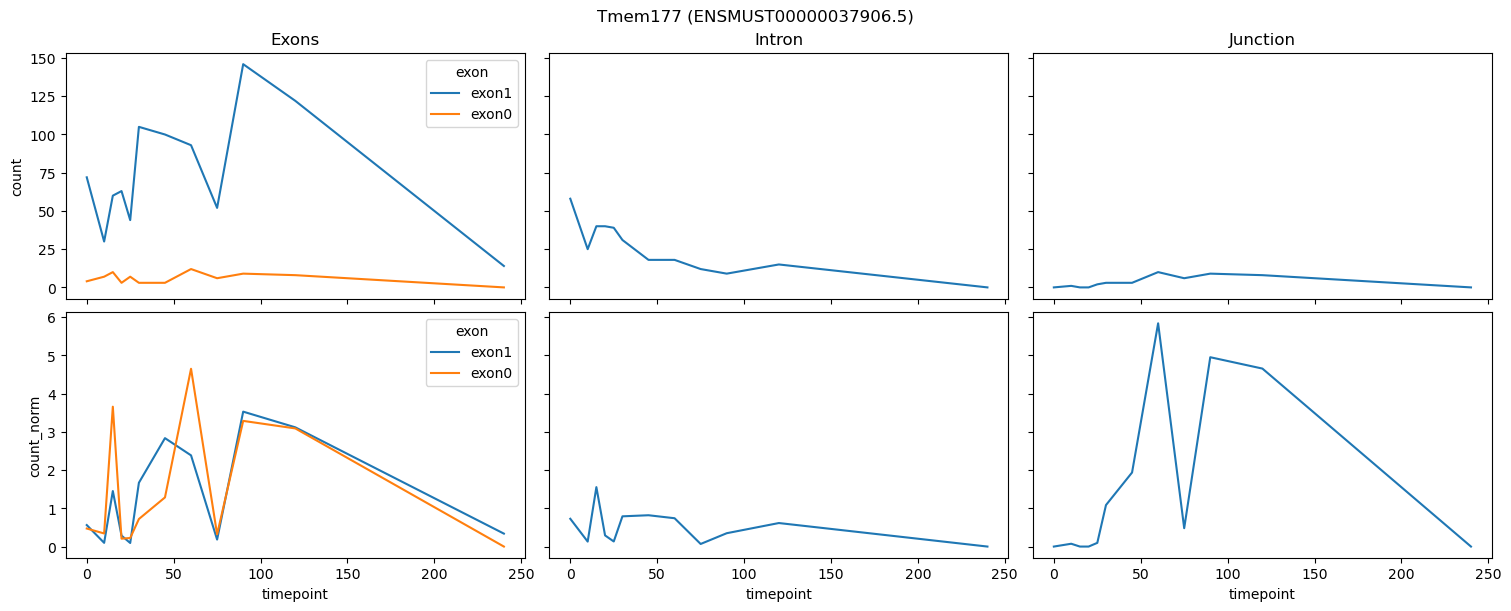

In [241]:
fig, axs = plt.subplots(2, 3, figsize=(15, 6), constrained_layout=True, sharex=True, sharey='row')
sns.lineplot(
    df_single_isoform_single_intron_counts_norm.loc[
        (df_single_isoform_single_intron_counts_norm['transcript_id'] == 'ENSMUST00000037906.5') &
        (df_single_isoform_single_intron_counts_norm['feature type'] == 'exon')] \
    .pipe(lambda df: df.assign(exon=df['start'].map({119913133: 'exon0', 119907890: 'exon1'}))),
    x='timepoint',
    y='count',
    hue='exon',
    ax=axs[0, 0])
sns.lineplot(
    df_single_isoform_single_intron_counts_norm.loc[
        (df_single_isoform_single_intron_counts_norm['transcript_id'] == 'ENSMUST00000037906.5') &
        (df_single_isoform_single_intron_counts_norm['feature type'] == 'exon')] \
    .pipe(lambda df: df.assign(exon=df['start'].map({119913133: 'exon0', 119907890: 'exon1'}))),
    x='timepoint',
    y='count_norm',
    hue='exon',
    ax=axs[1, 0])
sns.lineplot(
    df_single_isoform_single_intron_counts_norm.loc[
        (df_single_isoform_single_intron_counts_norm['transcript_id'] == 'ENSMUST00000037906.5') &
        (df_single_isoform_single_intron_counts_norm['feature type'] == 'intron')],
    x='timepoint',
    y='count',
    ax=axs[0, 1])
sns.lineplot(
    df_single_isoform_single_intron_counts_norm.loc[
        (df_single_isoform_single_intron_counts_norm['transcript_id'] == 'ENSMUST00000037906.5') &
        (df_single_isoform_single_intron_counts_norm['feature type'] == 'intron')],
    x='timepoint',
    y='count_norm',
    ax=axs[1, 1])
sns.lineplot(
    df_junction_counts_norm.loc[df_junction_counts_norm['transcript_id'] == 'ENSMUST00000037906.5'],
    x='timepoint',
    y='count',
    ax=axs[0, 2])
sns.lineplot(
    df_junction_counts_norm.loc[df_junction_counts_norm['transcript_id'] == 'ENSMUST00000037906.5'],
    x='timepoint',
    y='count_norm',
    ax=axs[1, 2])
axs[0, 0].set_title('Exons')
axs[0, 1].set_title('Intron')
axs[0, 2].set_title('Junction')
fig.suptitle('Tmem177 (ENSMUST00000037906.5)')
fig.show()

In [180]:
df_single_isoform_single_intron_counts_norm['count_norm'].describe()

count    2736.000000
mean        4.009654
std         8.866869
min         0.000000
25%         0.223781
50%         0.894916
75%         3.463042
max        91.808078
Name: count_norm, dtype: float64

In [183]:
df_junction_counts_norm['count_norm'].describe()

count    662.000000
mean       7.333720
std       14.938160
min        0.048363
25%        0.551420
50%        1.749390
75%        6.131961
max      109.442021
Name: count_norm, dtype: float64

## Single TSS Non-Overlapping Genes 

In [217]:
file_single_TSS_junction_counts = os.path.join(dir_data_aux, 'single_TSS_junction_counts.npz')
file_single_TSS_junction_counts_norm = os.path.join(dir_data_aux, 'single_TSS_junction_counts_norm.npz')
file_single_TSS_introns_exons = os.path.join(dir_data_aux, 'single_TSS_introns_exons.gtf.gz')

In [88]:
# Generate sorted GTF file of introns and exons for bedtools
pd.concat(
    (df_introns.loc[df_introns['transcript_id'].isin(transcript_ids_singleTSS_nonoverlapping_transcripts), columns_gtf],
     df_annot.loc[
        (df_annot['feature type'] == 'exon') &
        df_annot['transcript_id'].isin(transcript_ids_singleTSS_nonoverlapping_transcripts),
        columns_gtf]),
    axis=0) \
.astype(dict(chr=pd.CategoricalDtype(mouse_chromosomes_nuclear, ordered=True))) \
.sort_values(['chr', 'start', 'end']) \
.to_csv(file_single_TSS_introns_exons, sep='\t', header=False, index=False, quoting=csv.QUOTE_NONE)

In [89]:
%%bash -s {dir_data_dedup} {dir_data_aux} {file_single_TSS_introns_exons} {file_mm10_nuclear_sizes}
set -e -o pipefail

source ~/.bashrc

dir_data_dedup="$1"
dir_data_aux="$2"
path_annot="$3"
path_mm10_nuclear_sizes="$4"

dir_counts="${dir_data_aux}/single_TSS_counts"
mkdir -p "$dir_counts"

for path_dedup_bam in "$dir_data_dedup"/*.MarkDuplicates.dedup.bam; do
    file_dedup_bam="$(basename $path_dedup_bam)"
    timepoint="${file_dedup_bam%%.*}"
    file_out="${dir_counts}/${timepoint}.counts.gz"
    bedtools intersect \
        -c \
        -sorted \
        -g "$path_mm10_nuclear_sizes" \
        -a "$path_annot" \
        -b "$path_dedup_bam" | gzip > "$file_out" &
done
wait

In [123]:
# Collect counts for introns and exons
single_TSS_counts = []
for timepoint in timepoints:
    file_counts = os.path.join(dir_data_aux, 'single_TSS_counts', f'{timepoint}.counts.gz')
    single_TSS_counts.append(
        pd.read_csv(file_counts, sep='\t', header=None, names=columns_gtf + ['count']) \
        .assign(timepoint=timepoint))
single_TSS_counts = pd.concat(
    single_TSS_counts,
    axis=0,
    ignore_index=True) \
    .merge(df_normalization[['timepoint', 'denom']], how='left') \
    .pipe(lambda df: df.assign(count_norm=df['count'] / df['denom']))

In [119]:
# Counts for junctions
df_junction_counts_single_TSS = df_pysam.merge(df_normalization[['timepoint', 'denom']]) \
    .pipe(lambda df: df.assign(count_norm=df['count']/df['denom'])) \
    .merge(df_introns.loc[df_introns['transcript_id'].isin(transcript_ids_singleTSS_nonoverlapping_transcripts)], how='right') \
    .pipe(lambda df: df.assign(**{'feature type': df['feature type'].str.replace('intron', 'junction')})) \
    .groupby(['transcript_id', 'chr', 'start', 'end'], group_keys=False) \
    .apply(fill_missing_timepoints) \
    .astype({'timepoint': int, 'start': int, 'end': int, 'count': int, 'denom': float, 'count_norm': float})

In [124]:
# Combine counts for introns, exons, and junctions into a single DataFrame
single_TSS_counts = pd.concat(
    (df_junction_counts_single_TSS[columns_gtf + ['count', 'count_norm', 'timepoint', 'transcript_id']],
     single_TSS_counts[columns_gtf + ['count', 'count_norm', 'timepoint']] \
         .assign(transcript_id=single_TSS_counts['additional'].str.extract(r'transcript_id "([^"]+)"').squeeze())),
    axis=0) \
.reset_index(drop=True)

In [133]:
# assert that the numbers of intron, exon, and junction "feature type" entries match
tmp = single_TSS_counts.value_counts('feature type')
assert tmp['intron'] == tmp['junction']
assert tmp['exon'] == tmp['intron'] + len(single_TSS_counts['transcript_id'].unique()) * len(timepoints)

Convert counts into NumPy arrays of shape `(# timepoints, n_introns + 1, 3)`

In [186]:
def feature_gtf_to_junction_counts(df, value_col='count'):
    feature_type = df.name
    strand = df['strand'].unique()
    assert len(strand) == 1
    strand = strand[0]
    assert len(df['chr'].unique()) == 1
    if strand == '+':
        return df.sort_values('start')[value_col].values
    elif strand == '-':
        return df.sort_values('end', ascending=False)[value_col].values
    else:
        raise ValueError(f'strand of {strand} not recognized.')

def transcript_gtf_to_junction_counts(df, value_col='count'):
    series_counts = df.groupby('feature type').apply(feature_gtf_to_junction_counts, value_col=value_col)
    n_exons = len(series_counts['exon'])
    if n_exons == 1:
        raise NotImplementedError('Have not implemented case for intronless genes')
    assert len(series_counts['intron']) == n_exons - 1
    assert len(series_counts['junction']) == n_exons - 1
    data = np.zeros((n_exons, 3))
    data[:, 0] = series_counts['exon']
    data[:-1, 1] = series_counts['intron']
    data[:-1, 2] = series_counts['junction']
    return data

In [214]:
count_single_TSS = single_TSS_counts \
    .groupby(['transcript_id', 'timepoint']) \
    .apply(transcript_gtf_to_junction_counts, value_col='count')
for name, group in count_single_TSS.groupby(level=0, group_keys=False):
    assert group.loc[name].index.is_monotonic_increasing
np.savez_compressed(
    file_single_TSS_junction_counts,
    **{name: np.stack(group.values) for name, group in count_single_TSS.groupby(level=0, group_keys=False)})

In [218]:
count_norm_single_TSS = single_TSS_counts \
    .groupby(['transcript_id', 'timepoint']) \
    .apply(transcript_gtf_to_junction_counts, value_col='count_norm')
for name, group in count_norm_single_TSS.groupby(level=0, group_keys=False):
    assert group.loc[name].index.is_monotonic_increasing
np.savez_compressed(
    file_single_TSS_junction_counts_norm,
    **{name: np.stack(group.values) for name, group in count_norm_single_TSS.groupby(level=0, group_keys=False)})

### Visualize

In [314]:
count_single_TSS = np.load(file_single_TSS_junction_counts)
tmp = dict()
for transcript_id in count_single_TSS.files:
    mat = count_single_TSS[transcript_id]
    for i in range(12):
        tmp[(transcript_id, timepoints[i])] = mat[i]
count_single_TSS = pd.Series(tmp)

In [316]:
count_single_TSS.index.names = ['transcript_id', 'timepoint']

<AxesSubplot: xlabel='timepoint'>

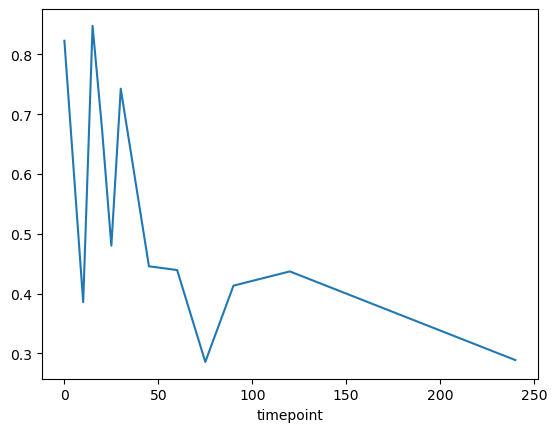

In [318]:
tmp = count_single_TSS.map(lambda x: x[0, 1]).rename('exon1').to_frame().reset_index()
tmp_norm = tmp.groupby('transcript_id', group_keys=False).apply(lambda df: df.assign(exon1=df['exon1'] / df['exon1'].max()))
avg = tmp_norm.groupby('timepoint')['exon1'].mean()
avg.plot()

In [320]:
tmp = count_norm_single_TSS.map(lambda x: x[0, 1]).rename('exon1').to_frame().reset_index()
tmp_norm = tmp.groupby('transcript_id', group_keys=False).apply(lambda df: df.assign(exon1=df['exon1'] / df['exon1'].max()))
avg = tmp_norm.groupby('timepoint')['exon1'].mean()

<AxesSubplot: xlabel='timepoint'>

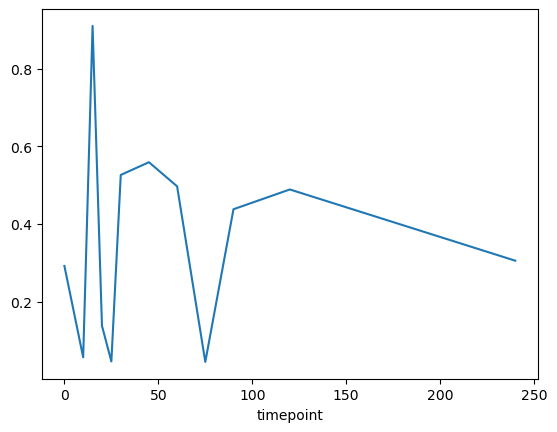

In [321]:
avg.plot()

<AxesSubplot: xlabel='timepoint', ylabel='exon1'>

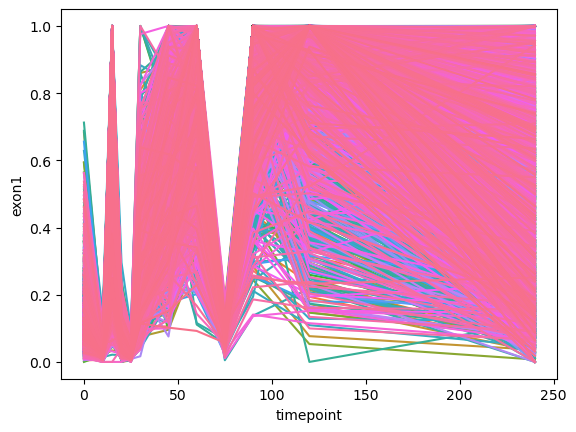

In [291]:
fig, ax = plt.subplots()
sns.lineplot(
    tmp_norm,
    x='timepoint',
    y='exon1',
    hue='transcript_id',
    estimator=None,
    legend=False,
    ax=ax)

## POU5F1 (OCT4)

In [ ]:
file_pou5f1 = os.path.join(dir_data_aux, 'pou5f1.gtf')

In [85]:
df_pou5f1_introns = utils_genomics.parse_transcript_gtf_to_introns(
    df_annot.loc[df_annot['additional'].str.contains('ENSMUST00000025271')],
    return_gene_length=False) \
    .sort_values('start')
df_pou5f1_introns['feature type'] = df_pou5f1_introns['feature type'] + np.arange(1, len(df_pou5f1_introns) + 1).astype(str)
df_pou5f1_exons = df_annot.loc[
    df_annot['additional'].str.contains('ENSMUST00000025271') &
    (df_annot['feature type'] == 'exon')] \
    .sort_values('start')
df_pou5f1_exons['feature type'] = df_pou5f1_exons['feature type'].astype(str) + np.arange(1, len(df_pou5f1_exons) + 1).astype(str)

In [87]:
df_pou5f1_annot = pd.concat((df_pou5f1_exons, df_pou5f1_introns), axis=0, ignore_index=True) \
    .sort_values(['start', 'end'])
df_pou5f1_annot.to_csv(file_pou5f1, sep='\t', index=False, header=False)

In [88]:
%%bash -s {dir_data_dedup} {dir_data_aux} {file_pou5f1} {file_mm10_nuclear_sizes}
set -e -o pipefail

source ~/.bashrc

dir_data_dedup="$1"
dir_data_aux="$2"
path_pou5f1="$3"
path_mm10_nuclear_sizes="$4"

dir_counts="${dir_data_aux}/pou5f1_counts"
mkdir -p "$dir_counts"

for path_dedup_bam in "$dir_data_dedup"/*.MarkDuplicates.dedup.bam; do
    file_dedup_bam="$(basename $path_dedup_bam)"
    timepoint="${file_dedup_bam%%.*}"
    file_out="${dir_counts}/${timepoint}.counts"
    bedtools intersect \
        -c \
        -sorted \
        -g "$path_mm10_nuclear_sizes" \
        -a "$path_pou5f1" \
        -b "$path_dedup_bam" > "$file_out" &
done
wait

In [94]:
df_junction_counts_norm_pou5f1 = df_pysam.merge(df_normalization[['timepoint', 'denom']]) \
    .pipe(lambda df: df.assign(count_norm=df['count']/df['denom'])) \
    .merge(df_pou5f1_introns, how='right') \
    .pipe(lambda df: df.assign(**{'feature type': df['feature type'].str.replace('intron', 'junction')})) \
    .groupby(['chr', 'start', 'end'], group_keys=False) \
    .apply(fill_missing_timepoints) \
    .astype({'timepoint': int, 'start': int, 'end': int, 'count': int, 'denom': float, 'count_norm': float})

In [95]:
df_pou5f1_counts = []
for timepoint in timepoints:
    file_counts = os.path.join(dir_data_aux, 'pou5f1_counts', f'{timepoint}.counts')
    df_pou5f1_counts.append(
        pd.read_csv(file_counts, sep='\t', header=None, comment='#', names=columns_gtf + ['count']) \
        .assign(timepoint=timepoint))
df_pou5f1_counts = pd.concat(
    df_pou5f1_counts,
    axis=0,
    ignore_index=True) \
    .merge(df_normalization[['timepoint', 'denom']], how='left') \
    .pipe(lambda df: df.assign(count_norm=df['count'] / df['denom']))

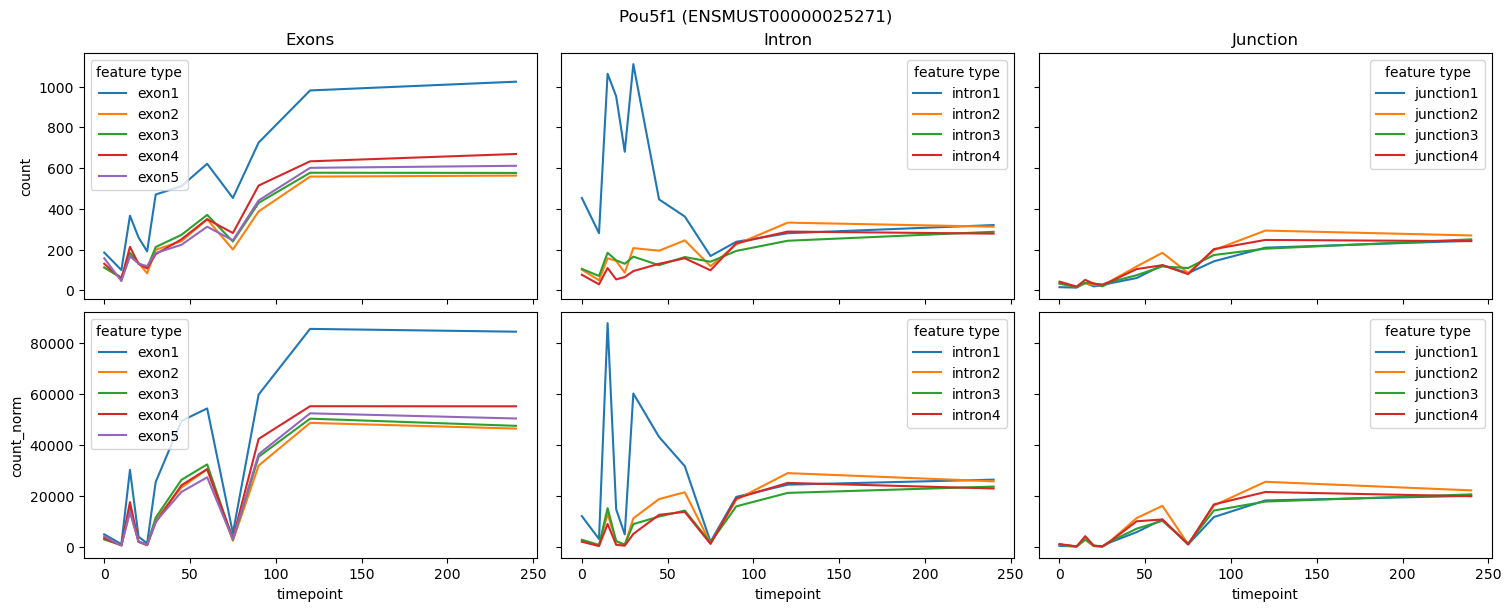

In [98]:
fig, axs = plt.subplots(2, 3, figsize=(15, 6), constrained_layout=True, sharex=True, sharey='row')
sns.lineplot(
    df_pou5f1_counts.loc[df_pou5f1_counts['feature type'].str.startswith('exon')],
    x='timepoint',
    y='count',
    hue='feature type',
    ax=axs[0, 0])
sns.lineplot(
    df_pou5f1_counts.loc[df_pou5f1_counts['feature type'].str.startswith('exon')],
    x='timepoint',
    y='count_norm',
    hue='feature type',
    ax=axs[1, 0])
sns.lineplot(
    df_pou5f1_counts.loc[df_pou5f1_counts['feature type'].str.startswith('intron')],
    x='timepoint',
    y='count',
    hue='feature type',
    ax=axs[0, 1])
sns.lineplot(
    df_pou5f1_counts.loc[df_pou5f1_counts['feature type'].str.startswith('intron')],
    x='timepoint',
    y='count_norm',
    hue='feature type',
    ax=axs[1, 1])
sns.lineplot(
    df_junction_counts_norm_pou5f1,
    x='timepoint',
    y='count',
    hue='feature type',
    ax=axs[0, 2])
sns.lineplot(
    df_junction_counts_norm_pou5f1,
    x='timepoint',
    y='count_norm',
    hue='feature type',
    ax=axs[1, 2])
axs[0, 0].set_title('Exons')
axs[0, 1].set_title('Intron')
axs[0, 2].set_title('Junction')
fig.suptitle('Pou5f1 (ENSMUST00000025271)')
fig.show()

### TODO: Check if promoter-paused read peak is higher for POU5F1 than other genes